---

---

# ACM40960 Projects in Maths Modelling - 
# Monte Carlo Simulation of Fixtures and a Profitable Betting System for the English Premier League

---

---

# 1. Data Loading and Preparation

---

### - Load relevant libraries

Import all relevant libraries and functions into the notebook.

In [14]:
# import all required libraries and functions
import pandas as pd
from pandas import DataFrame
import glob
import math
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import linear_model
import mord
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.stats import probplot
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.special import boxcox as spboxcox
from scipy.special import inv_boxcox
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from collections import Counter
import random
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier as boost
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier as adaboost
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression as logreg
from random import shuffle
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.metrics import log_loss
from scipy.special import softmax

---

### - Load the data

Load the data from all csv files in the Data folder, and merge into a single data frame.

In [21]:
# function that gets all csv files in the given path, extracts the specified columns, and returns a
# single dataframe combining the data from all of the files
def load_csv_files(path, columns):
    # Get file names of all csv files in the specified path
    filenames = sorted(glob.glob(path + "/*.csv"))
    # create empty list to store data frames from each csv file
    li = []

    # loop through all csv file names
    for filename in filenames:
        # read in specified columns for current file, drop rows with NAs
        df = pd.read_csv(filename, usecols=columns).dropna()
        # append dataframe from current EPL year to list
        li.append(df)

    # combine all data frames in list into a single data frame, and reset row indices
    df = pd.concat(li, axis=0)
    df.reset_index(drop=True, inplace=True)
    
    return df

The columns that we require are *HomeTeam*, *AwayTeam* and *FTR* (i.e. full-time result). We can use the previous function to load each of the scv files in the given folder path, extract the relevant data and return a single dataframe. The obtained *EPL_original* dataframe is displayed below.

In [22]:
# get EPL data from csv files in the 'Data' folder (get 'HomeTeam', 'AwayTeam' and 'FTR'data)
EPL_original = load_csv_files('Data/', ['HomeTeam', 'AwayTeam', 'FTR'])

In [23]:
EPL_original

,HomeTeam,AwayTeam,FTR
0,Aston Villa,Man United,H
1,Blackburn,QPR,H
2,Chelsea,Everton,D
3,Liverpool,Sheffield Weds,H
4,Man City,Tottenham,D
...,...,...,...
9495,Leicester,Man United,A
9496,Man City,Norwich,H
9497,Newcastle,Liverpool,A
9498,Southampton,Sheffield United,H


---

### - Calculate known metrics from the data

The function below calculates the total number of points earned by each team each in the current season, and results obtained for each team in each fixture of each season. 

It then takes a dataframe of the form of the *EPL_original* dataframe above, and adds new columns for both home and away teams, containing:

- proportion of total number of points achieved in the current season,
- proportion of total number of points achieved last season where possible (not possible for newly promoted teams),
- proportion of possible points achieved in the past 5 games where possible (not possible for teams' first 5 games of each season)
- appropriated scaled versions of all these columns (e.g. logit transformations of the proportion of total number of points achieved columns)

The function returns the updated *EPL* dataframe, along with new dataframes containing win/lose/draw/points counts for each team for each season, points per game for each team across each game of each season, and a 5 game form metric for each team across each game of each season.

In [45]:
def processEPLdata(df, num_seasons, games_per_season):
    # copy dataframe to new dataframe called EPL
    EPL = df.copy()
    # add column to store season integer, set all to 0 initially
    EPL.insert(0,"Season",0)
    # add columns to EPL to store '% of total points earned for the whole season' for home and away teams 
    EPL['HomePPC'] = np.nan
    EPL['AwayPPC'] = np.nan
    ## add columns to EPL to store '% of total points earned for the whole season from LAST YEAR' for home and away teams 
    EPL['HomePPCprev'] = np.nan
    EPL['AwayPPCprev'] = np.nan
    ## add columns to EPL to store form values for home and away teams (% points in past 5 games)
    EPL['HomeForm5'] = np.nan
    EPL['AwayForm5'] = np.nan

    # set start/end indices for the first season of fixtures
    start_ind = 0
    end_ind = games_per_season
    # set number of games to include for form (use 5 as default)
    form_games = 5

    # create empty dataframes to save season stats, PPG and form stats for every team for all seasons
    all_seasons_WLD = DataFrame()
    all_seasons_ppg = DataFrame()
    all_seasons_form = DataFrame()
    
    # print progress update message
    print("Number of seasons processed ( out of", num_seasons, "): ", end="")
    
    # loop through all 25 seasons worth of data
    for season in range(0,num_seasons):
        
        # get list of unique teams in the current season
        teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

        # create dataframe with relevant columns, add teams as the 1st column
        WLD_cols = ['W','D','L','PointsTot','PointsPC']
        teams_WLD = DataFrame(columns=WLD_cols)
        teams_WLD.insert(0,"Team",teams)

        ## create data frame to store points in each game
        teams_ppg = DataFrame(columns=range(1,39))
        teams_ppg.insert(0,"Team",teams)
        ## create data frame to store 5 game form
        teams_form = DataFrame(columns=range(1,39))
        teams_form.insert(0,"Team",teams)

        # loop through all teams in the current season
        for team in teams:
            # count total no. of wins/losses/draws for each team in the current season
            Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
            Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
            Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
            # count total number of points and % of overall points for each team
            Points = 3*Ws + 1*Ds
            PointsPC = Points / (38*3)
            # add season stats for current team to the dataframe
            teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]

        # sort by highest points
        teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)

        # add column for current season index
        teams_WLD.insert(0,"Season",season)
        teams_ppg.insert(0,"Season",season)
        teams_form.insert(0,"Season",season)

        # loop through each fixture in the current season
        for game in range(start_ind,end_ind):
            # add current season integer to the EPL dataframe
            EPL.at[game,'Season']=season
            # add overall points % for the home and away teams in the current fixture
            home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
            away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
            EPL.at[game,'HomePPC']=home_pc
            EPL.at[game,'AwayPPC']=away_pc

            # if Season>0, check if home/away team in each fixture was in league last season and
            # add last seasons overall points % if so
            if season>0:
                teams_WLD_prev = all_seasons_WLD[all_seasons_WLD['Season']==(season-1)]
                # check if current fixture home team were in league last season
                if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['HomeTeam'])):
                    home_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC'].astype(float)
                    EPL.at[game,'HomePPCprev']=home_pc_prev

                # check if current fixture away team were in league last season
                if any(teams_WLD_prev['Team'].str.contains(EPL.iloc[game,]['AwayTeam'])):
                    away_pc_prev = teams_WLD_prev[teams_WLD_prev['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC'].astype(float)
                    EPL.at[game,'AwayPPCprev']=away_pc_prev

            ## Get home and away team names
            hometeam = EPL.iloc[game,]['HomeTeam']
            awayteam = EPL.iloc[game,]['AwayTeam']
            ## determine points for home and away team (will remain 0 if team has lost)
            HomePts = AwayPts = 0
            if EPL.iloc[game,]['FTR'] == 'D':
                HomePts = AwayPts = 1
            elif EPL.iloc[game,]['FTR'] == 'H':
                HomePts = 3
            else :
                AwayPts = 3

            ## get next available game index of home team, add home team points to teams_ppg dataframe
            home_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==hometeam,].isna()).iloc[0]].min()
            teams_ppg.loc[teams_ppg['Team']==hometeam, home_nextfree] = HomePts
            ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
            if home_nextfree > form_games:
                home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-(form_games-1)):(home_nextfree+1)].values.sum()/(form_games*3.0)
                teams_form.loc[teams_form['Team']==hometeam, home_nextfree] = home_form5
                EPL.at[game,'HomeForm5'] = home_form5

            ## get next available game index of away team, add away team points to teams_ppg dataframe
            away_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==awayteam,].isna()).iloc[0]].min()
            teams_ppg.loc[teams_ppg['Team']==awayteam, away_nextfree] = AwayPts
            ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
            if away_nextfree > form_games:
                away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-(form_games-1)):(away_nextfree+1)].values.sum()/(form_games*3.0)
                teams_form.loc[teams_form['Team']==awayteam, away_nextfree] = away_form5
                EPL.at[game,'AwayForm5'] = away_form5

        # add current season stats for each team to main dataframe
        all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
        all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
        all_seasons_form = all_seasons_form.append(teams_form)

        # increment start/end indices to correspond with fixtures for next season
        start_ind = start_ind + games_per_season
        end_ind = end_ind + games_per_season
        
        # print latest season that has been completed
        print(season+1, end=" ")
    
    # return updated EPL dataframe, along with summary dataframes
    return EPL, all_seasons_WLD, all_seasons_ppg, all_seasons_form

We can call the function below using the *EPL_original* dataframe as an input argument, along with values for the number of seasons and number of games per season. The updated *EPL* dataframe (outputted by this function) has also been plotted below.

In [46]:
# get no. of seasons (number of csv files in the data path)
N_seasons = len(sorted(glob.glob("Data/*.csv")))
# get no. of games per season (20 teams choose 2, multiply by 2 for home/away fixtures)
N_gps = math.comb(20, 2) * 2

# call EPL data processing function
EPL, all_seasons_WLD, all_seasons_ppg, all_seasons_form = processEPLdata(EPL_original, N_seasons, N_gps)

Number of seasons processed ( out of 25 ): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

In [47]:
EPL # current EPL dataframe after intitial data processing

,Season,HomeTeam,AwayTeam,FTR,HomePPC,AwayPPC,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5
0,0,Aston Villa,Man United,H,0.552632,0.719298,NaN,NaN,NaN,NaN
1,0,Blackburn,QPR,H,0.535088,0.289474,NaN,NaN,NaN,NaN
2,0,Chelsea,Everton,D,0.438596,0.535088,NaN,NaN,NaN,NaN
3,0,Liverpool,Sheffield Weds,H,0.622807,0.350877,NaN,NaN,NaN,NaN
4,0,Man City,Tottenham,D,0.333333,0.535088,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9495,24,Leicester,Man United,A,0.543860,0.578947,0.456140,0.578947,0.466667,0.733333
9496,24,Man City,Norwich,H,0.710526,0.184211,0.859649,NaN,0.800000,0.000000
9497,24,Newcastle,Liverpool,A,0.385965,0.868421,0.394737,0.850877,0.133333,0.666667
9498,24,Southampton,Sheffield United,H,0.456140,0.473684,0.342105,NaN,0.600000,0.466667


I will also display the top 3 rows from the other 3 dataframes returned by the function.

In [49]:
display(all_seasons_WLD.head(3))
display(all_seasons_ppg.head(3))
display(all_seasons_form.head(3))

,Season,Team,W,D,L,PointsTot,PointsPC
10,0,Man United,25,7,6,82,0.719298
12,0,Newcastle,24,6,8,78,0.684211
8,0,Liverpool,20,11,7,71,0.622807


,Season,Team,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,0,Arsenal,1,3,1,1,3,3,3,0,...,3,3,0,3,3,0,1,1,1,3
1,0,Aston Villa,3,3,0,3,1,3,1,3,...,3,3,0,1,3,3,0,1,0,0
2,0,Blackburn,3,0,0,0,1,0,3,0,...,1,3,3,0,0,3,3,3,1,3


,Season,Team,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,0,Arsenal,NaN,NaN,NaN,NaN,NaN,0.6,0.733333,0.733333,...,0.533333,0.733333,0.866667,0.666667,0.666667,0.8,0.6,0.466667,0.533333,0.4
1,0,Aston Villa,NaN,NaN,NaN,NaN,NaN,0.666667,0.666667,0.533333,...,0.666667,0.666667,0.666667,0.6,0.466667,0.666667,0.666667,0.466667,0.533333,0.466667
2,0,Blackburn,NaN,NaN,NaN,NaN,NaN,0.266667,0.0666667,0.266667,...,0.4,0.266667,0.266667,0.466667,0.466667,0.466667,0.6,0.6,0.6,0.666667


---

# 2. Visualising and Transforming the Original Data

---

### - Pairs plot of original data

Firstly, I will create an initial pairs plot of the columns in the EPL data frame which will be considered for when predicting the home win / draw / away win probabilities for new simulated fixtures.

It was not possible to dertermine 'Form5' values and 'PPCprev' values in every case for a number of reasons (e.g. cannot calculate 5 game form for games where teams haven't yet played 5 games, cannot determine percentage of total points in previous season value for newly promoted teams) so we will need to impute these values. I will use regression methods to impute reaonable values in each case, but in order to use such methods one assumption that needs to be considered is that the data used should be normally distriuted.

Note that from the plot below, both the 'HomeForm5' and 'AwayForm5' variables appear to follow a vague normal shape, but the distributions of 'HomePPCprev' and 'AwayPPCprev' are both skewed positively.

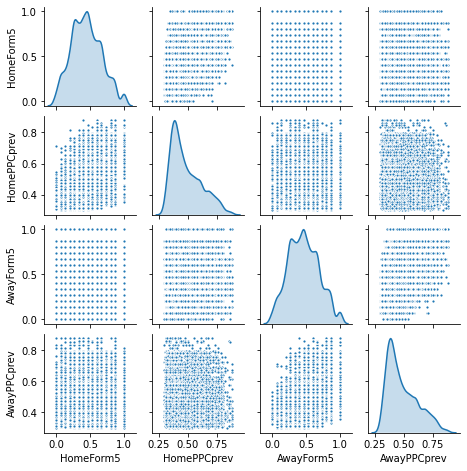

In [65]:
ax = sns.pairplot(EPL[['HomeForm5','HomePPCprev', 'AwayForm5', 'AwayPPCprev']], diag_kind='kde', height=1.6,
                 plot_kws=dict(marker="."))

---

### - Box Cox Transformations

In order to 'improve' the distributions of the 'PPCprev' variables, appropriate Box Cox transformations can be used to reduce the skewness in each case. I will define two new columns containing the transformed 'PPCprev' variables after performing optimal Box Cox transformations - 'HomePPCprev_tf' and 'AwayPPCprev_tf'.

In [66]:
# get optimum lambda values for boxcox transformations of home and away PPC previous data
home_lambda = boxcox(EPL['HomePPCprev'].dropna())[1]
away_lambda = boxcox(EPL['AwayPPCprev'].dropna())[1]

In [67]:
# create new columns with boxcox transformed Home/AwayPPCprev data
EPL['HomePPCprev_tf'] = spboxcox(EPL['HomePPCprev'], home_lambda)
EPL['AwayPPCprev_tf'] = spboxcox(EPL['AwayPPCprev'], away_lambda)

For comparative purposes, I have plotted the distribution of the original variables along with their QQ-plots (showing how close the data are to following a normal distribution) on the top row below, and the equivalent plots for the transformed variables bottom row.

Although the transformed variables appear to move further away from a normal distribution towards both tails, the boxcox transformations appear to have improved their distributions overall.

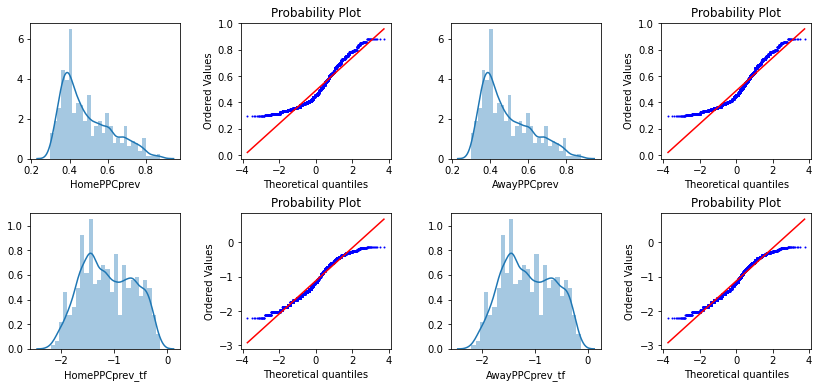

In [71]:
# set up plot size to plot 8 separate plot (2 rows of 4 plots)
fig = plt.figure(figsize=(14,6))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for original PPCprev data
ax1 = plt.subplot(241); plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(242); plot2 = probplot(EPL['HomePPCprev'].dropna(), dist=norm, plot=plt)
ax2.get_lines()[0].set_markersize(1)
ax3 = plt.subplot(243); plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(244); plot4 = probplot(EPL['AwayPPCprev'].dropna(), dist=norm, plot=plt)
ax4.get_lines()[0].set_markersize(1)

# plot distribution and QQ-plot for boxcox transformed PPCprev data
ax5 = plt.subplot(245); plot5 = sns.distplot(EPL['HomePPCprev_tf'])
ax6 = plt.subplot(246); plot6 = probplot(EPL['HomePPCprev_tf'].dropna(), dist=norm, plot=plt)
ax6.get_lines()[0].set_markersize(1)
ax7 = plt.subplot(247); plot7 = sns.distplot(EPL['AwayPPCprev_tf'])
ax8 = plt.subplot(248); plot8 = probplot(EPL['AwayPPCprev_tf'].dropna(), dist=norm, plot=plt)
ax8.get_lines()[0].set_markersize(1)

---

### - Pairs plot with transformed data

I'll now recreate the pairs plot of the data but also showing the 'PPC' variables and the newly transformed 'PPCprev_tf' variables, but this time with scatter plots and regression lines shown on the lower triangle, density plots shown on the diagonal and correlation dots shown on the upper triangle of the grid of plots.

To show the correlation dots, we need to define a function for plotting dots with colour and size proportional to correlation coefficient value, which can be used to visulaise correlation between variables on a PairGrid pairs plot.

In [72]:
def corrdot(*args, **kwargs):
    corr_r=args[0].corr(args[1], 'pearson')
    corr_text=f"{corr_r:2.2f}".replace("0.", ".")
    ax=plt.gca()
    ax.set_axis_off()
    marker_size=abs(corr_r)*10000
    ax.scatter([.5],[.5],marker_size,[corr_r],alpha=0.6,cmap="coolwarm",
              vmin=-1, vmax=1, transform=ax.transAxes)
    font_size=abs(corr_r)*40+5
    ax.annotate(corr_text, [.5, .5,], xycoords="axes fraction",
               ha='center', va='center', fontsize=font_size)

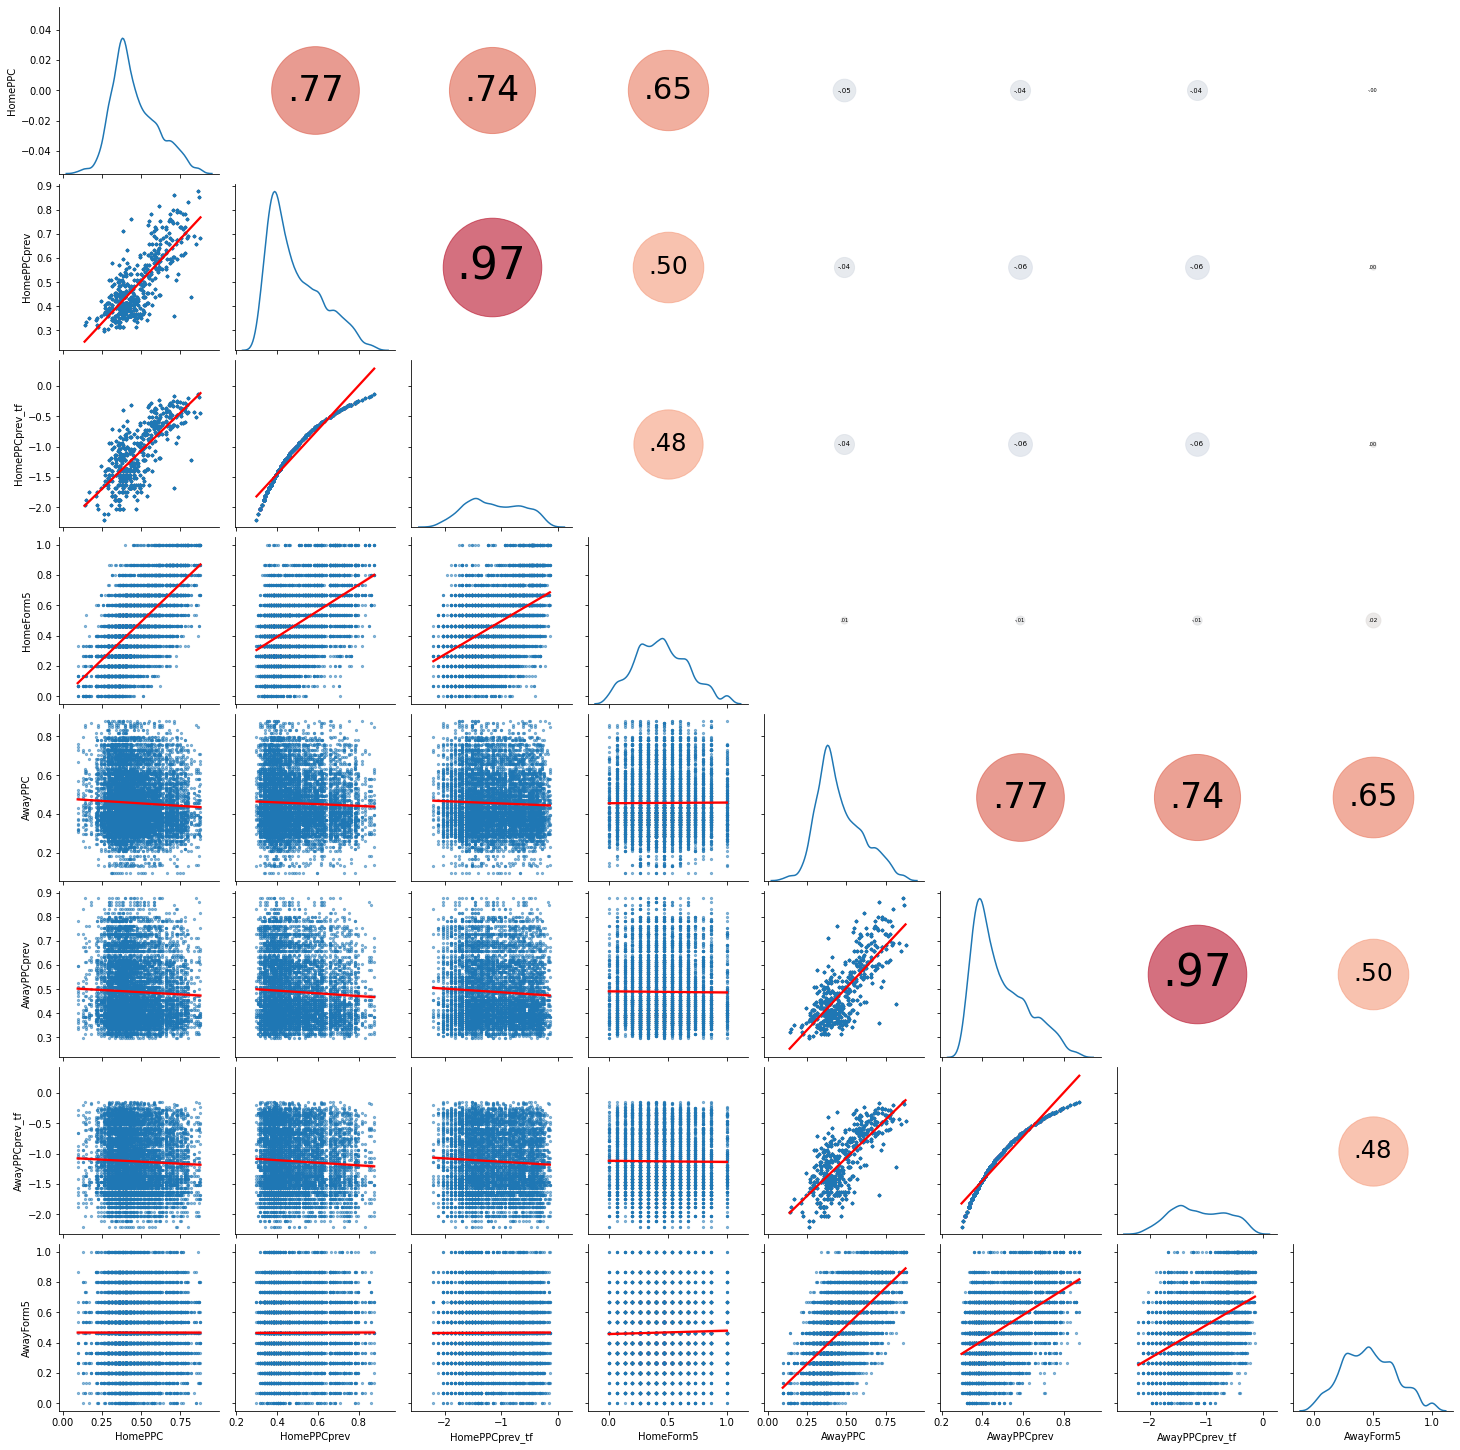

In [75]:
g=sns.PairGrid(EPL[['HomePPC','HomePPCprev','HomePPCprev_tf','HomeForm5','AwayPPC','AwayPPCprev','AwayPPCprev_tf','AwayForm5']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

---

### - Visualising Relationship Between 'HomePPCprev'/'AwayPPCprev' and 'FTR'

Firstly, we can look at the the proportion of each of the classes within the available 'FTR' data to identify if the home win, draw, and away win classes are balanced.

From the plot below, the number of draw and away win occurences are very similar but home wins have a significantly higher rate of occurence. This will need to be considered later when fitting and evalutating the performance of competing classification models.

Proportion of Home Wins: 0.46 
Proportion of Draws: 0.26 
Proportion of Away Wins: 0.28


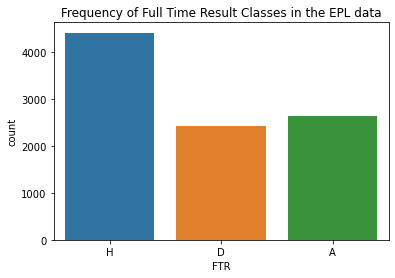

In [76]:
# print proportion of each class
print("Proportion of Home Wins:", np.round((EPL['FTR']=='H').sum()/EPL.shape[0], 2),
      "\nProportion of Draws:", np.round((EPL['FTR']=='D').sum()/EPL.shape[0], 2),
      "\nProportion of Away Wins:", np.round((EPL['FTR']=='A').sum()/EPL.shape[0], 2))

# plot frequency of each class in barplot format
p1=sns.countplot(EPL['FTR'])
ax=p1.set_title("Frequency of Full Time Result Classes in the EPL data")

We can also use a number of plots to help visualise the relationship between 'HomePPCprev', 'AwayPPCprev' and 'FTR'. Below, the scatter plot shows the 'HomePPCprev' and 'AwayPPCprev' values for all fixtures (where available) and with data point colours based off the result. While there is no clear separation visible between the classes, There appears to be a slightly higher concentration of 'H' results near the bottom right of the plot (i.e. high 'HomePPCprev' value and low 'AwayPPCprev' value), and a slightly higher concentration of 'A' results near the top left of the plot (i.e. high 'AwayPPCprev' value and low 'HomePPCprev' value) which would be expected.

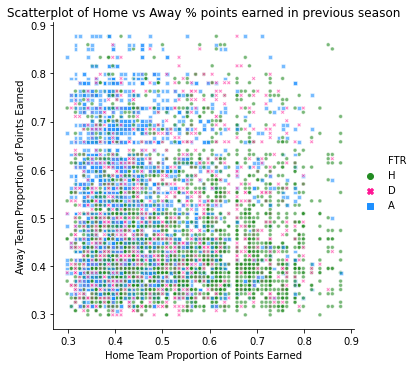

In [77]:
plot1 = sns.relplot(data=EPL, x='HomePPCprev', y='AwayPPCprev', hue='FTR', style='FTR', kind='scatter', s=15, alpha=0.6,
            palette=dict(H='forestgreen', D='deeppink', A='dodgerblue')).set(xlabel='Home Team Proportion of Points Earned',
                                             ylabel='Away Team Proportion of Points Earned', title='Scatterplot of Home vs Away % points earned in previous season')

The boxplots below show the distribution of the difference in 'HomePPCprev' and 'AwayPPCprev' values for each fixture, again separated based on the full time result. There appears to be a clear relationship between the difference in the percentage of points earned by the home and away teams in the previous season and the full time result based on this plot.

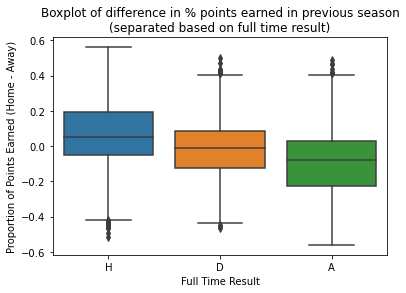

In [78]:
plot2 = sns.boxplot(EPL['FTR'], EPL['HomePPCprev']-EPL['AwayPPCprev']).set(xlabel='Full Time Result', ylabel='Proportion of Points Earned (Home - Away)',
                                                title='Boxplot of difference in % points earned in previous season\n(separated based on full time result)')

---

### - Visualising Relationship Between 'HomeForm5'/'AwayForm5' and 'FTR'

We can produce similar plots to visualise the relationship between 'HomeForm5', 'AwayForm5' and 'FTR'. 

As there are only 15 possible achievable form values, many of the points on the scatter plot would overlap making it difficult to visualise the data in such a plot. Therefore, I have created a copy of the EPL dataframe below, and added random noise (or jitter) to the form values so that it is easier to visulaise the data.

A similar trend to the 'PPCprev' scatter plot above is observed, with home wins more prominent as home form increases and away form decreases, and away wins more prominent as away form increases and home form decreases.

In [79]:
EPL_copy = EPL.copy()
# create vectors of uniform random jitter values between -0.5 and 0.5
rand_unif1 = np.random.uniform(low=-0.5, high=0.5, size=EPL_copy.shape[0])
rand_unif2 = np.random.uniform(low=-0.5, high=0.5, size=EPL_copy.shape[0])
# add random jitter to the 'Form5' columns
EPL_copy['HomeForm5'] = EPL_copy['HomeForm5'] + rand_unif1
EPL_copy['AwayForm5'] = EPL_copy['AwayForm5'] + rand_unif2

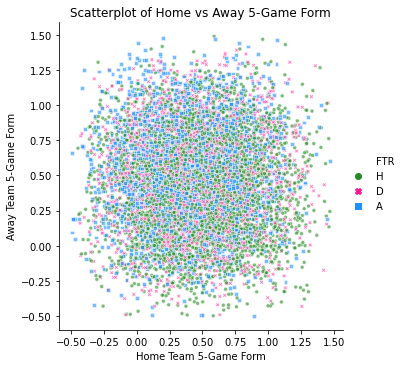

In [80]:
plot3 = sns.relplot(data=EPL_copy, x='HomeForm5', y='AwayForm5', hue='FTR', style='FTR', kind='scatter', s=15, alpha=0.6,
            palette=dict(H='forestgreen', D='deeppink', A='dodgerblue')).set(xlabel='Home Team 5-Game Form',
                                             ylabel='Away Team 5-Game Form', title='Scatterplot of Home vs Away 5-Game Form')

The boxplots below show the distribution of the difference in 'HomeForm5' and 'AwayForm5' values for each fixture, again separated based on the full time result. Again, there appears to be a relationship visible between form and full time result.

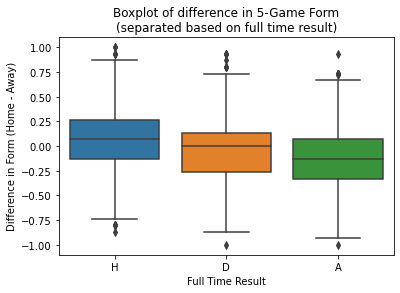

In [81]:
plot4 = sns.boxplot(EPL['FTR'], EPL['HomeForm5']-EPL['AwayForm5']).set(xlabel='Full Time Result', ylabel='Difference in Form (Home - Away)',
                                                title='Boxplot of difference in 5-Game Form\n(separated based on full time result)')

---

# 3. Imputing Missing Values

---

### - Analysis of variables with missing values

There are several cases where it was not possible to calculate the proportion of points earned by a team in the previous year (i.e. cases where teams are newly promoted, and for all teams in the first available season) and the form value over the past 5 games (i.e. first 5 games for each team each season).

From the correlation dots on the pairs plot above (and as would be expected), we can see that there is a relatively strong correlation between the proportion of points earned by teams in the current season and they're 5 game form value, so it seems reaonable to use the home and away proportion of points earned in the current season to impute the unknown values of 5 game home form and away form respectively. As there are only a finite number of possible form values that a team can have, and they are bounded between 0 and 15, I will use ordinal logistic regression to estimate the probabilities for each unknown form value of being each of the possible 15 values, and I will randomly sample from these probabilities as an estimate of the unknown form value (rather than choosing most probable value, to preserve variance in the data).

Likewise, there is a similarly strong correlation between the proportion of points earned by teams in the current season and the proportion of points they earned in the previous season. We can use this relationship to impute values for the unknown proportion of points earned in the previous year values using simple linear regression.

In [85]:
print("Correlation between Home variables (Form):", EPL['HomePPC'].corr(EPL['HomeForm5']), 
      "\nCorrelation between Away variables (Form):", EPL['AwayPPC'].corr(EPL['AwayForm5']))

Correlation between Home variables (Form): 0.645440698475821 
Correlation between Away variables (Form): 0.6505244996144792


In [86]:
print("Correlation between Home variables (PPCprev):", EPL['HomePPC'].corr(EPL['HomePPCprev_tf']), 
      "\nCorrelation between Away variables (PPCprev):", EPL['AwayPPC'].corr(EPL['AwayPPCprev_tf']))

Correlation between Home variables (PPCprev): 0.7416225709613654 
Correlation between Away variables (PPCprev): 0.7416225723584337


We can also visualise this relationship using scatter plots with a lowess regression line overlaid. As shown below, the relationship in each case (even though there is a significant amount of variation in the data) is approximately linear.

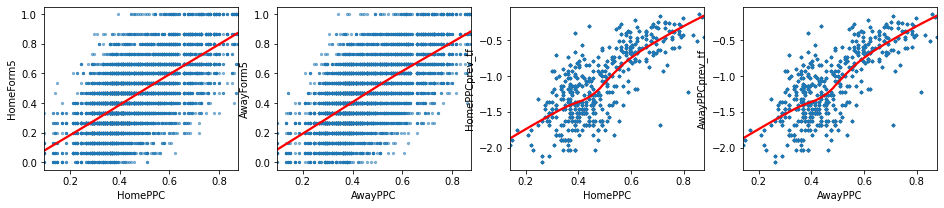

In [87]:
# set up plot size
plt.figure(figsize=(16,3))

ax1 = plt.subplot(141)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax2 = plt.subplot(142)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax3 = plt.subplot(143)
plot3 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax4 = plt.subplot(144)
plot4 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})

---

### - Imputing missing 'Form5' values

We will use the proportion of points earned by teams in the current season to impute their form values in cases where the form values couldn't be calculated. First we can effectively create training and test sets for the data, where training sets include HomePPC/AwayPPC and HomeForm5/AwayForm5 values for all cases where the HomeForm5/AwayForm5 values are available, and test sets include the HomePPC/AwayPPC values for the remaining cases where HomeForm5/AwayForm5 values are not available.

After training separate models for the home and away data, the predicted probabilities of belonging to each 'class' (i.e. 0,1,..,12,13,15, with all values divided by 15 to return a form value in the range 0 to 1) for each item in the test data is calculated, and the final estimated value in each case is obtained by randomly sampling the class value based on the associated class probabilities.

In [88]:
# split home form and PPC data into train and test (test will be all NaN values in HomeForm5 column)
home_x_test = EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomePPC']]
home_x_train = EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomePPC']]
home_y_train = (EPL.loc[EPL.loc[:,'HomeForm5'].notna(),['HomeForm5']]).values.squeeze()

# split away form and PPC data into train and test (test will be all NaN values in AwayForm5 column)
away_x_test = EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayPPC']]
away_x_train = EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayPPC']]
away_y_train = (EPL.loc[EPL.loc[:,'AwayForm5'].notna(),['AwayForm5']]).values.squeeze()

In [89]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

After encoding the form values, ordinal logistic regression models can be fitted to the 'training' data above, and these models can be used to predict the probabilities associated with each possible form value for the 'test' data where the 'Form5' values couldn't be directly calcuated for a team.

In [90]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))
# generate class probabilities for the test data from the model
home_y_predprobs = ord_reg_home.predict_proba(home_x_test)

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))
# generate class probabilities for the test data from the model
away_y_predprobs = ord_reg_away.predict_proba(away_x_test)

After obtaining class probabilities above for the unknown form values, we could just take the highest probability class and use this as the imputed value in each case. However, this can reduce the variance in the variable where the values are being imputed and can result in overestimation in the correlation between variables. 

To reduce the likelihood of these issues occurring, I have decided to perform a stochastic method of imputation, sampling each of the unknown form values randomly using the predicted probabilities.

In [91]:
# create list of possible form values (integers from 0 to 15 but with 14 omitted)
form_classes = list(range(16))
form_classes.remove(14)
# loop through all values in the list and divide by 15 (to give a value in the range of 0 to 1)
for i in range(len(form_classes)): form_classes[i] = form_classes[i]/15

# create 1d arrays of zeros to store estimated form values
home_y_pred = np.zeros(home_y_predprobs.shape[0])
away_y_pred = np.zeros(away_y_predprobs.shape[0])

# set seed
np.random.seed(20203868)

# loop through all rows of the predicted probabilities array 
for i in range(home_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = home_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    home_y_pred[i] = np.random.choice(form_classes, 1, p=problist)
    
# loop through all rows of the predicted probabilities array 
for i in range(away_y_predprobs.shape[0]):
    # get list of class probabilities for the current form value
    problist = away_y_predprobs[i,:]
    # sample the form value based on the probabilities, add to array of predicted values
    away_y_pred[i] = np.random.choice(form_classes, 1, p=problist)

Plotting density plots of the original and imputed values for Home and Away 'Form5' values shows that they appear to follow very similar distributions, and the scatter plots below plotting the original and imputed 'Form5' values versus their corresponding 'PPC' values appears to show similar variance in the original and imputed data as desired.

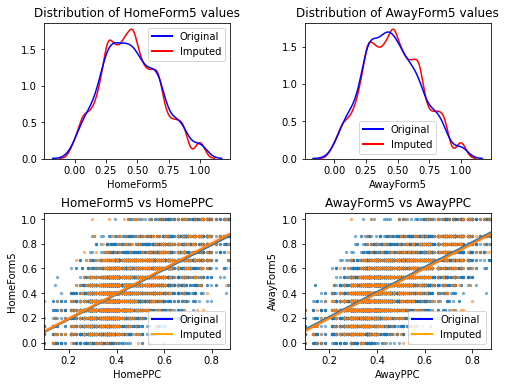

In [95]:
# set up plot size
plt.figure(figsize=(8,6))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution of original and newly imputed HomeForm5 values
ax1 = plt.subplot(221)
plot1 = sns.kdeplot(home_y_train, legend=True, color='r').set(title='Distribution of HomeForm5 values', xlabel='HomeForm5')
plot2 = sns.kdeplot(home_y_pred, legend=True, color='b')
plot2.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)], ['Original', 'Imputed'])

# plot distribution of original and newly imputed AwayForm5 values
ax2 = plt.subplot(222)
plot3 = sns.kdeplot(away_y_train, legend=True, color='r').set(title='Distribution of AwayForm5 values', xlabel='AwayForm5')
plot4 = sns.kdeplot(away_y_pred, legend=True, color='b')
plot4.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)], ['Original', 'Imputed'])

# plot original and newly imputed HomeForm5 values vs HomePPC
ax3 = plt.subplot(223)
plot5 = sns.regplot(home_x_train, home_y_train, scatter_kws={'alpha':0.5, 's':5}).set(title='HomeForm5 vs HomePPC', ylabel='HomeForm5')
plot6 = sns.regplot(home_x_test, home_y_pred, scatter_kws={'alpha':0.5, 's':5})
plot6.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

# plot original and newly imputed AwayForm5 values vs AwayPPC
ax4 = plt.subplot(224)
plot7 = sns.regplot(away_x_train, away_y_train, scatter_kws={'alpha':0.5, 's':5}).set(title='AwayForm5 vs AwayPPC', ylabel='AwayForm5')
plot8 = sns.regplot(away_x_test, away_y_pred, scatter_kws={'alpha':0.5, 's':5})
ax = plot8.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

As the imputed values appear to be reasonable, they can be added to the EPL dataframe.

We can now recreate the last 2 plots above but with the original and imputed 'Form5' values now combined in the EPL dataframe.

In [96]:
# add imputed form values to the EPL dataframe
EPL.loc[EPL.loc[:,'HomeForm5'].isna(),['HomeForm5']] = home_y_pred
EPL.loc[EPL.loc[:,'AwayForm5'].isna(),['AwayForm5']] = away_y_pred

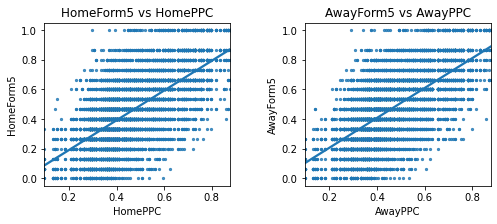

In [97]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution of original and newly imputed HomeForm5 values
ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomeForm5'], scatter_kws={'s':5}).set(title='HomeForm5 vs HomePPC')
# plot distribution of original and newly imputed AwayForm5 values
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayForm5'], scatter_kws={'s':5}).set(title='AwayForm5 vs AwayPPC')

---

### - Imputing missing 'PPCprev' values

We will use the proportion of points earned by teams in the current season to impute the proportion of points they earned in the previous season in cases where these values couldn't be calculated. First we can effectively create training and test sets for the data. 

Linear regression will firm the basis of the imputation method in this instance, but again for the reasons mentioned above when imputing form values a stochastic regression imputation method will be used. Here, we will first fit linear regression models on all data where 'PPCprev' values are available, and predict 'PPCprev' values for all cases where this couldn't be determined. We will then randomly sample the imputed value from a normal distribution with mean equal to the predicted 'PPCprev' value, and standard deviation equal to the standard error in the 'training' data.

Ideally, these linear regression models should satisfy the assumption of homoskedasticity, meaning that the residuals of the model should have a constant variance across the range of 'PPC' values. If there is significant differences  in the variance across the range of 'PPC' values, then adding random noise to the predicted values based on the overall standard error of the data will not be a valid method of performing stochastic imputation, as we will tend to significantly overestimate or underestimate the standard error in certain cases depedning on the predicted 'PPCprev' value.

Comparing residual plots for the 'HomePPCprev' and 'HomePPCprev_tf' variables versus 'HomePPC', it appears that the transformed 'HomePPCprev_tf' values follow closer to this assumption than the original data, so I will use the boxcox transformed data when fitting the models initially.

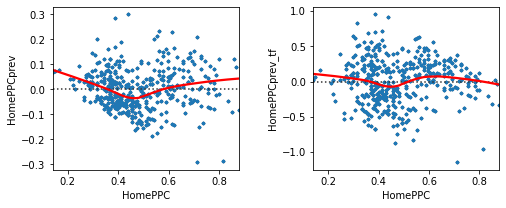

In [98]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(121)
plot1 = sns.residplot(EPL['HomePPC'], EPL['HomePPCprev'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
ax2 = plt.subplot(122)
plot2 = sns.residplot(EPL['HomePPC'], EPL['HomePPCprev_tf'], lowess=True, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})

Another potential issue that needs to be considered is that the 'PPCprev' values we need to predict are bounded in the range of 0 to 1. Therefore, it is possible that after adding the random noise to our predicted values, they could potentially fall outside of this range. There are a number of ways to deal with this, such as clamping values between the range of 0 to 1, but this could result in an excessive number of 0 and 1 values.

Instead, I have decided to first take the predicted 'PPCprev_tf' values from the linear regression models and perform the inverse of the boxcox transformation used earlier to change them to the same form as the 'PPCprev' data. Then I will use a logit transformation on these data, and at this stage I will add the random noise value (based on a similarly scaled value of the standard error of the original data). And finally I will use a logistic transformation to reverse the logit transformation, and return imputed 'PPCprev' values which are bounded between 0 and 1. I have defined the logit and logistic transformation functions below.

In [99]:
# logit transformation function
def logit_tf(p):
    return np.log(p / (1-p))
# logistic transformation function
def logistic_tf(x):
    return 1 / (1 + np.exp(-x))

Again, we can create 'training' data based on the data where 'PPCprev' values were available, and the 'test' data in this case will be all cases where 'PPCprev' values couldn't be determined, and linear regression models can be fitted using the training data.

In [100]:
# split home form and PPC data into train and test (test will be all NaN values in HomePPCprev_tf column)
homep_x_test = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPC']]
homep_x_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPC']]
homep_y_train = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].notna(),['HomePPCprev_tf']]

# split away form and PPC data into train and test (test will be all NaN values in AwayPPCprev_tf column)
awayp_x_test = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPC']]
awayp_x_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPC']]
awayp_y_train = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].notna(),['AwayPPCprev_tf']]

In [101]:
# fit linear regression model to home training data, predict values for the missing HomePPCprev values
regr_homep = linear_model.LinearRegression()
regr_homep.fit(homep_x_train, homep_y_train)
homep_y_pred = regr_homep.predict(homep_x_test)

# fit linear regression model to away training data, predict values for the missing AwayPPCprev values
regr_awayp = linear_model.LinearRegression()
regr_awayp.fit(awayp_x_train, awayp_y_train)
awayp_y_pred = regr_awayp.predict(awayp_x_test)

Then the standard error in the training data can be obtained by transforming the training data appropriately (perform inverse of the boxcox transformation used earlier, and then perform logit transformation) and getting the standard deviation of the transformed data. This value can then be used to add an appropriate level of stochastic noise to the predicted 'PPCprev' values.

Also, as teams should have a constant 'PPCprev' value across each season, I have added the same random noise value for each individual team in each season across all of their games, rather than them having a different value in each case. 

In [102]:
# calculate standard error for known home PPCprev values (after logit transformation)
home_stderror = logit_tf(inv_boxcox(homep_y_train, home_lambda)).std()

# get data frame containing list of teams in each season with no PPCprev values
NoPPCprev = (EPL.loc[(EPL.loc[:,'HomePPCprev_tf'].isna()), ['Season', 'HomeTeam']]).drop_duplicates()

np.random.seed(13579) # set seed

# get random normal samples to add to predicted home/away PPC prev values 
# (with home PPCprev strandard error)
PPCprev_rand = np.random.normal(size = len(NoPPCprev), loc = 0, scale = home_stderror)
NoPPCprev['rand'] = PPCprev_rand

In [103]:
# get dataframe of all fixtures where home team has no PPCprev value
homep_NoPPCprev = EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['Season', 'HomeTeam']]
# add predicted values for home teams' PPC prev after boxcox and logit transorming the data
homep_NoPPCprev['Pred'] = logit_tf(inv_boxcox(homep_y_pred, home_lambda))
# add column to store random values
homep_NoPPCprev['Rand'] = 0.0
# reset row indices
homep_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(homep_NoPPCprev.shape[0]):
    # get random normal value for the current home team/current season
    hometeam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==homep_NoPPCprev.iloc[game,]['HomeTeam']) &
    (NoPPCprev['Season']==homep_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    homep_NoPPCprev.at[game,'Rand'] = hometeam_rand

# add random normal noise to predicted values and perform logisitc transform
homep_NoPPCprev['PredRand'] = logistic_tf(homep_NoPPCprev['Pred'] + homep_NoPPCprev['Rand'])

In [104]:
# get dataframe of all fixtures where away team has no PPCprev value
awayp_NoPPCprev = EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['Season', 'AwayTeam']]
# add predicted values for away teams' PPC prev
awayp_NoPPCprev['Pred'] = logit_tf(inv_boxcox(awayp_y_pred, home_lambda))
# add column to store random values
awayp_NoPPCprev['Rand'] = 0.0
# reset row indices
awayp_NoPPCprev.reset_index(drop=True, inplace=True)

# loop through each fixture in the data frame
for game in range(awayp_NoPPCprev.shape[0]):
    # get random normal value for the current away team/current season
    awayteam_rand = NoPPCprev[(NoPPCprev['HomeTeam']==awayp_NoPPCprev.iloc[game,]['AwayTeam']) &
    (NoPPCprev['Season']==awayp_NoPPCprev.iloc[game,]['Season'])]['rand'].astype(float)
    # add random value to the Rand column
    awayp_NoPPCprev.at[game,'Rand'] = awayteam_rand

# add random normal noise to predicted values and perform logisitc transform
awayp_NoPPCprev['PredRand'] = logistic_tf(awayp_NoPPCprev['Pred'] + awayp_NoPPCprev['Rand'])

Plotting scatterplots of the original and new imputed 'PPCprev' values shows that the imputed values do appear to follow the trend of the original data, and appear to have a similar level of variance.

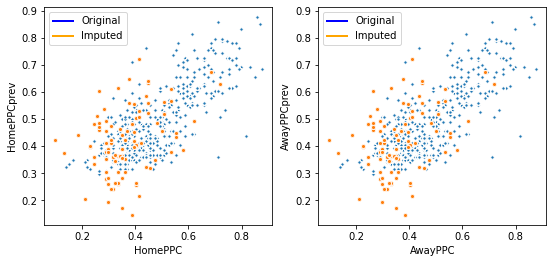

In [105]:
# set up plot size
plt.figure(figsize=(9,4))

ax1 = plt.subplot(121)
p1=sns.scatterplot(np.array(homep_x_train).squeeze(), np.array(inv_boxcox(homep_y_train, home_lambda)).squeeze(), s=10)
p2=sns.scatterplot(np.array(homep_x_test).squeeze(), homep_NoPPCprev['PredRand'], s=15).set(xlabel="HomePPC", ylabel="HomePPCprev")
p1.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

ax2 = plt.subplot(122)
p3=sns.scatterplot(np.array(awayp_x_train).squeeze(), np.array(inv_boxcox(awayp_y_train, away_lambda)).squeeze(), s=10)
p4=sns.scatterplot(np.array(awayp_x_test).squeeze(), awayp_NoPPCprev['PredRand'], s=15).set(xlabel="AwayPPC", ylabel="AwayPPCprev")
p3.legend([Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='orange', lw=2)], ['Original', 'Imputed'])

As the imputed values seem reasonable, they can be added to the EPL dataframe. The scatter plots below show the same data as the previous scatter plots, but the imputed data is now included in the EPL dataframe with the original data.

In [106]:
# add values to the EPL data frame
EPL.loc[EPL.loc[:,'HomePPCprev_tf'].isna(),['HomePPCprev_tf']] = boxcox(homep_NoPPCprev['PredRand'].values, home_lambda)
EPL.loc[EPL.loc[:,'AwayPPCprev_tf'].isna(),['AwayPPCprev_tf']] = boxcox(awayp_NoPPCprev['PredRand'].values, away_lambda)

# add transformed values to the EPL data frame
# (inverse of boxcox transformations performed earlier)
EPL.loc[EPL.loc[:,'HomePPCprev'].isna(),['HomePPCprev']] = homep_NoPPCprev['PredRand'].values
EPL.loc[EPL.loc[:,'AwayPPCprev'].isna(),['AwayPPCprev']] = awayp_NoPPCprev['PredRand'].values

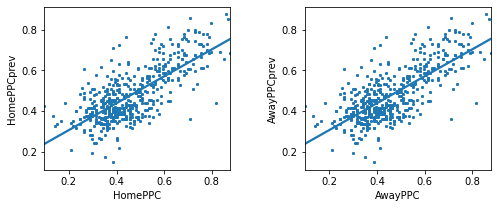

In [107]:
# set up plot size
plt.figure(figsize=(8,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(121)
plot1 = sns.regplot(EPL['HomePPC'], EPL['HomePPCprev'], scatter_kws={'s':1})
ax2 = plt.subplot(122)
plot2 = sns.regplot(EPL['AwayPPC'], EPL['AwayPPCprev'], scatter_kws={'s':1})

---

### - Visualising the data after imputation

We can now recreate the pairs plot from earlier showing each of the continuous variables of interest to our model, but now with no missing values.

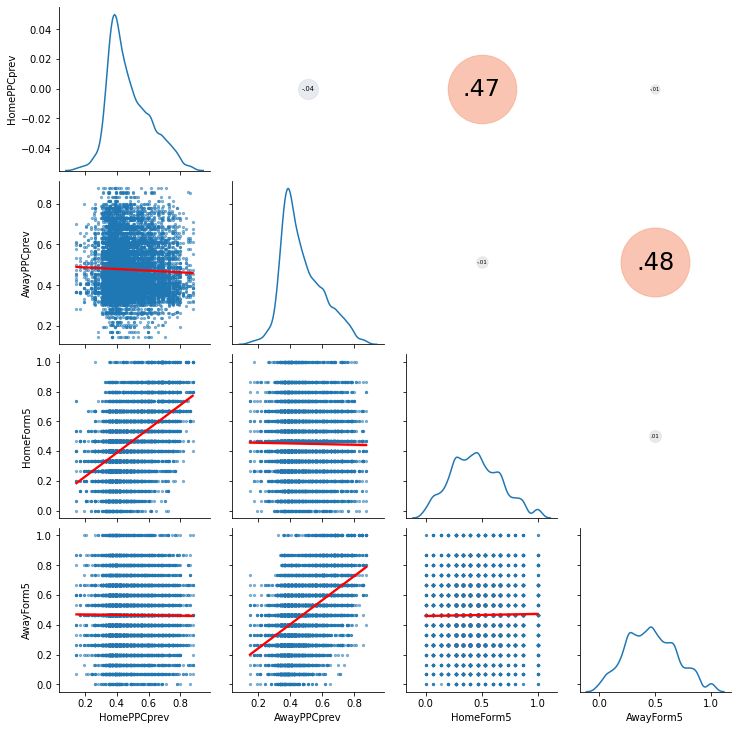

In [108]:
g=sns.PairGrid(EPL[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5', 'FTR']])
g=g.map_lower(sns.regplot, scatter_kws={'alpha':0.5, 's':5}, line_kws={'color':'red'})
g=g.map_diag(sns.kdeplot)
g=g.map_upper(corrdot)

If we look at QQ-plots again for the home and away form values (with the newly imputed values included) we can see that they both appear to follow an approximate normal distribution, though the tails cut off abruptly as expected due to the possible form values being bounded between 0 and 1.

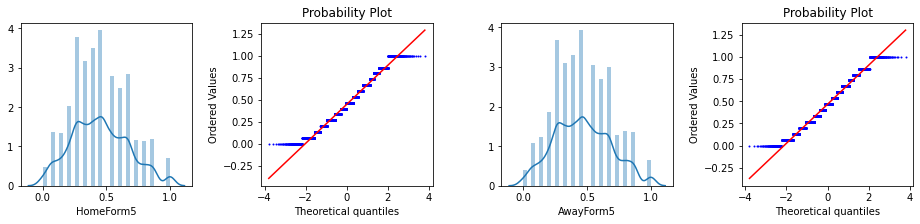

In [109]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomeForm5'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomeForm5'], dist=norm, plot=plt)
ax2.get_lines()[0].set_markersize(1)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayForm5'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayForm5'], dist=norm, plot=plt)
ax4.get_lines()[0].set_markersize(1)

Likewise, looking at QQ-plots for the home and away PPC prev values (with the newly imputed values included) we can see that they also appear to roughly follow a normal distribution, although the distribution of the data deviates somewhat from this towards the tails. This is again likely due to the number of achieveable points in a season - and hence proportion of points obtained in the previous season - being bounded.

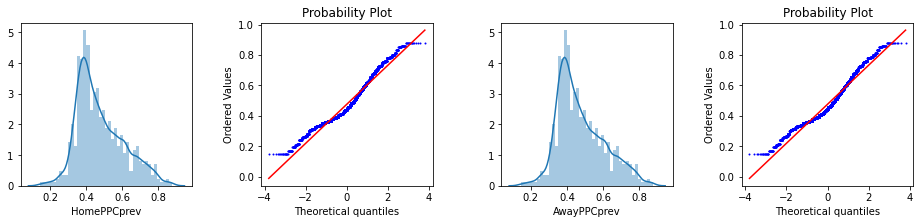

In [110]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot distribution and QQ-plot for PPCprev data
ax1 = plt.subplot(141)
plot1 = sns.distplot(EPL['HomePPCprev'])
ax2 = plt.subplot(142)
plot2 = probplot(EPL['HomePPCprev'], dist=norm, plot=plt)
ax2.get_lines()[0].set_markersize(1)
ax3 = plt.subplot(143)
plot3 = sns.distplot(EPL['AwayPPCprev'])
ax4 = plt.subplot(144)
plot4 = probplot(EPL['AwayPPCprev'], dist=norm, plot=plt)
ax4.get_lines()[0].set_markersize(1)

After completing the imputation, the EPL dataframe no longer has missing values.

In [111]:
EPL # display EPL dataframe after imputation of all unknown values

,Season,HomeTeam,AwayTeam,FTR,HomePPC,AwayPPC,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5,HomePPCprev_tf,AwayPPCprev_tf
0,0,Aston Villa,Man United,H,0.552632,0.719298,0.435934,0.630382,0.866667,0.800000,-1.238644,-0.572989
1,0,Blackburn,QPR,H,0.535088,0.289474,0.377574,0.304263,0.866667,0.266667,-1.564615,-2.141451
2,0,Chelsea,Everton,D,0.438596,0.535088,0.585177,0.569180,0.866667,0.400000,-0.689974,-0.735610
3,0,Liverpool,Sheffield Weds,H,0.622807,0.350877,0.493327,0.363035,0.400000,0.466667,-0.990213,-1.661315
4,0,Man City,Tottenham,D,0.333333,0.535088,0.615496,0.610523,0.533333,0.133333,-0.609702,-0.622348
...,...,...,...,...,...,...,...,...,...,...,...,...
9495,24,Leicester,Man United,A,0.543860,0.578947,0.456140,0.578947,0.466667,0.733333,-1.144383,-0.707460
9496,24,Man City,Norwich,H,0.710526,0.184211,0.859649,0.440083,0.800000,0.000000,-0.162093,-1.218616
9497,24,Newcastle,Liverpool,A,0.385965,0.868421,0.394737,0.850877,0.133333,0.666667,-1.459220,-0.173913
9498,24,Southampton,Sheffield United,H,0.456140,0.473684,0.342105,0.351272,0.600000,0.466667,-1.814251,-1.745131


---

# 4. Evaluating Machine Learning Models for Predicting Result Probabilities 

---

### - Visualising the relationship between predictor variables and 'FTR'

Before fitting models in order to generate predict full time result probabilities for new fixtures, we can again look at some boxplots to visualise whether an relationship exists between the 'HomePPCprev', 'AwayPPCprev', 'HomeForm5' and 'AwayForm5' variables (which I plan to use as predictor variables in the model) and the 'FTR' variable (which will be the target variable in the model). 

In each case, there appears to be evidence of such a relationship based off these plots.

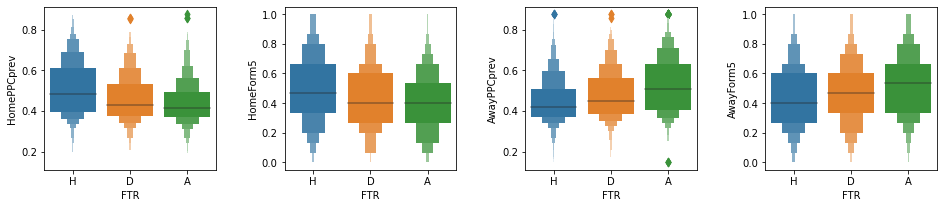

In [112]:
# set up plot size
plt.figure(figsize=(16,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# plot boxplots
ax1 = plt.subplot(141); plot1=sns.boxenplot(EPL['FTR'], EPL['HomePPCprev'])
ax2 = plt.subplot(142); plot2=sns.boxenplot(EPL['FTR'], EPL['HomeForm5'])
ax3 = plt.subplot(143); plot3=sns.boxenplot(EPL['FTR'], EPL['AwayPPCprev'])
ax4 = plt.subplot(144); plot4=sns.boxenplot(EPL['FTR'], EPL['AwayForm5'])

---

### - Functions for cross-validation and evaluation

Next, I will define a number of functions which can be reused when fitting and evaluating each of the models being tested. The first function takes a list of data in the form of folds to be used in k-fold cross-validation, as well as the number of folds and the current fold iteration. Based on these arguments, it returns the sets of training and validation data for the current iteration of the cross-validation.

In [113]:
def get_train_val_folds(folds, numfolds, k):
    # use current fold as the current validation set
    val_fold = folds[k]
    # separate x and y validation data based on columns
    valx = val_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    valy = val_fold['FTR'].values

    # combine remaining folds to use as current training set
    train_ind_list = list(range(numfolds))
    train_ind_list.remove(k)
    train_fold = pd.concat([folds[i] for i in train_ind_list])
    # separate x and y training data based on columns
    trainx = train_fold[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
    trainy = train_fold['FTR'].values
    
    # return training and validation sets for current iteration
    return trainx, trainy, valx, valy

The function below takes a given model, fits it using given training data, and returns predicted class probabilities for given validation data.

In [114]:
# function to fit data to given model and predict values for validation data
def model_fit_predict(model, trainx, trainy, valx):
    # fit training data to model
    model.fit(trainx, trainy)
    # get class predictions and class probabilities
    preds_mod = model.predict(valx)
    probs_mod = model.predict_proba(valx)
    # return class predictions and class probabilities
    return model, preds_mod, probs_mod

The next function below takes a target variable whose entries may be of string type. It then performs label encoding to convert the string values to numeric values, and finally it performs one hot encoding on the numeric vector and returns an array corresponding to the one hot encoded target variable. This functionality is required when calculating the Ranked Probability Score for each model, which will be described later.

In [115]:
# function to perform one hot encoding on class vector in string format 
def myOneHotEncoder(targets):
    le = LabelEncoder() # define label encoder object
    targets_num = le.fit_transform(targets) # generate numeric vector corresponding to classes
    enc = OneHotEncoder() # define one hot encoder object
    return enc.fit_transform(targets_num.reshape(-1, 1)).toarray() # return one hot encoded array

The next function generates an array corresponding to class probabilities for the specified target variable, but each row has identical class probabilities corresponding to the proportion of each of the classes in the given training data. These probabilities will be used for generating a reference or baseline model which will in turn be used to evaluate the performance of each model via the Ranked Probability Skill Score.

In [116]:
# function to calculate reference probabilities based off class proportions in training data
def get_ref_probs(targets, classes, trainy):
    N = len(targets) # number of observations
    probs0 = np.array([0.0]*len(classes)) # create vector of 0s, length equal to number of classes
    
    # loop through each class
    for i in range(len(classes)):
        probs0[i] = len(trainy[trainy==classes[i]])/len(trainy) # calculate proportion of current class in the training data
    
    probs = np.array([probs0,]*N) # create array of length num.observations with reference probabilities repeated
    
    return probs

The following 2 functions are then used to calculate the Ranked Probability Score (RPS) and Ranked Probability Skill Score (RPSS) for each of our models, which is the metric I have chosen to evaluate and compare the performance of each model. Note that the RPS/RPSS take into account the ordinal nature of our target variable and the target variable and corresponding predicted class probabilities must be ordered appropriately for the metric to be valid (i.e. order of classes must be either A-D-H or H-D-A).

The RPSS compares the model to the reference/baseline model as descrived above, with a positive value indicating an improvement on the reference model and a negative value indicating a worse performance than the reference model.

In [117]:
# function to calculate ranked probability score
# both targets and probs must be ordered appropriately (e.g. A,D,H or H,D,A)
def rps(targets, probs):
    targets = myOneHotEncoder(targets) # use one hot encoding to convert target vector to binary array
    RPS = 0
    N = targets.shape[0] # number of observations
    r = targets.shape[1] # number of classes
    
    for t in range(N): # loop through all rows (observations)
        for i in range(r-1): # loop through classes (minus the final class)
            inner_sum = 0 # initialise the inner sum value as 0
            
            for j in range(i+1): # loop from 0 to i+1
                inner_sum += (probs[t, j] - targets[t, j]) # add difference between current prob. and target value to inner sum
                
            RPS += inner_sum**2 # square inner sum value after completion of inner loop
            
    RPS = RPS/((r-1)*N) # divide RPS by num.classes-1, and also by num.observations
    
    return RPS

In [118]:
# calculate ranked probability skill score
def rpss(rps, rps_ref):
    return 1 - (rps/rps_ref)

The following function combines the functions above to fit training data to a given model, generate predicted class probabilities for given validation data, and evaluate the performance of the model via the RPSS metric.

In [119]:
# function to fit model and evaluate on validation data using RPSS
# (Ranked Probability Skill Score)
def fit_eval_rpss(model, trainx, trainy, valx, valy):
    # predict classes and get class probabilities for validation data
    model, preds_mod, probs_mod = model_fit_predict(model, trainx, trainy, valx)
    
    # get ranked probability score for the validation data using predicted classes
    RPS = rps(valy, probs_mod)
    
    # get probabilities for reference case where training data proportions are used
    ref_probs = get_ref_probs(valy, np.unique(trainy), trainy)
    # get ranked probability skill score for the validation data using predicted classes
    RPS_ref = rps(valy, ref_probs)
    RPSS = rpss(RPS, RPS_ref)
    
    return RPSS

I have also defined a plotting function which takes an array of RPSS values calculated during a cross-validation procedure for multiple models and plots both boxplots showing the distribution of RPSS values obatined for each model, and also a line plot showing the mean RPSS value obatined for each model.

In [121]:
def plot_rpss(rpss_data):    
    # set up plot size
    plt.figure(figsize=(9,4))
    # increase spacing between figures
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # plot boxplots
    ax1 = plt.subplot(121); plot1 = sns.boxplot(data=rpss_data)
    ax1.plot(np.mean(rpss_data, axis=0),'r-o',linewidth=2)
    # plot mean values
    ax2 = plt.subplot(122); plot2 = plt.plot(np.mean(rpss_data, axis=0))
    ax2.set_xticks(range(rpss_data.shape[1]))
    plt.grid()

Finally, I have defined 2 functions which can be used to track the progress of the cross-validation procedure, producing a progress bar corresponding to the percentage of completion (based on the number of folds and reps executed).

In [122]:
def progress_bar_init(num_reps, num_folds):
    # print starting time
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Cross-Validation Starting Time =", current_time, "\n")
    
    # print header
    print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
              num_reps, "reps,", num_folds, "folds )")
    # return starting values of 0 for progress/progress_last/progress_diff
    return 0,0,0

In [123]:
def progress_bar(rep, k, num_reps, num_folds, progress, progress_last, progress_diff):
    # update values for progress bar
    progress = ((rep)*num_folds + (k+1))/((num_reps)*(num_folds))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")
    
    # return current values for progress/progress_last/progress_diff
    return progress, progress_last, progress_diff

---

### - Random Forest Models Evaluation

I will now trial a number of different random forest models to see which configuation is most capable at at predicting the outcome probabilities for fixture based on the form and points achieved by teams in theur previous season.

I will perform multiple repetitions of K-fold cross-validation for each model configuration, calculating the average Ranked Probability Skill Score metric in each case, which I will use to choose the best final configuration. I am tuning 2 hyperparameters for my random forest models, the number of estimators *(n_estimators)* and the maximum depth *(max_depth)*.

Cross-Validation Starting Time = 18:24:19 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Random Forest Parameters: [1600, 5]
CPU times: user 13min 59s, sys: 4.65 s, total: 14min 3s
Wall time: 14min 4s


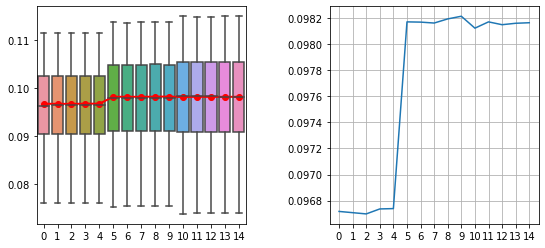

In [124]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
rf_params = np.array([[800, 4], [1000, 4], [1200, 4], [1400, 4], [1600, 4],
                      [800, 5], [1000, 5], [1200, 5], [1400, 5], [1600, 5],
                      [800, 6], [1000, 6], [1200, 6], [1400, 6], [1600, 6]])
num_models = len(rf_params)

# print header for the progress bar and initialise variables
prog, prog_last, prog_diff = progress_bar_init(num_reps, num_folds)

# create array of zeros to store rpss values for each model over each rep/fold
rf_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds): # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Random Forest models
        for j in range(num_models):
            rf_mod = rf(n_estimators=rf_params[j,0], max_depth=rf_params[j,1], random_state=0)
            rf_rpss[k + rep*num_folds,j] = fit_eval_rpss(rf_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        prog, prog_last, prog_diff = progress_bar(rep, k, num_reps, num_folds, prog, prog_last, prog_diff)

print("\n\nComplete!")

rf_params_opt = list(rf_params[np.argmax(np.mean(rf_rpss, axis=0))])
print("Optimum Random Forest Parameters:", rf_params_opt)

# plot RPSS results       
plot_rpss(rf_rpss)

---

### - Gradient Boosting Models Evaluation

Next I will evaluate a number of different gradient boosting models.

Again, I will use cross-validation methods to evaluate the performance of multiple different model configurations via the Ranked Probability Skill Score metric. I am tuning 2 hyperparameters for my gradient boosting models, the number of estimators *(n_estimators)* and the maximum depth *(max_depth)*.

Cross-Validation Starting Time = 18:38:45 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Gradient Boosting Parameters: [150, 1]
CPU times: user 2min 49s, sys: 955 ms, total: 2min 50s
Wall time: 2min 50s


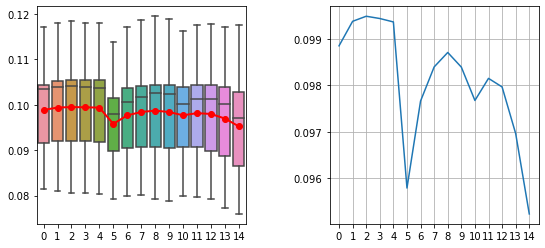

In [125]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
boost_params = np.array([[100, 1], [125, 1], [150, 1], [175, 1], [200, 1],
                         [30, 2], [40, 2], [50, 2], [75, 2], [100, 2],
                         [30, 3], [40, 3], [50, 3], [75, 3], [100, 3]])

num_models = len(boost_params)

# print header for the progress bar and initialise variables
prog, prog_last, prog_diff = progress_bar_init(num_reps, num_folds)

# create array of zeros to store rpss values for each model over each rep/fold
boost_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Gradient Boosting models
        for j in range(num_models):
            boost_mod = boost(n_estimators=boost_params[j,0], max_depth=boost_params[j,1], random_state=0)
            boost_rpss[k + rep*num_folds, j] = fit_eval_rpss(boost_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        prog, prog_last, prog_diff = progress_bar(rep, k, num_reps, num_folds, prog, prog_last, prog_diff)

print("\n\nComplete!")

boost_params_opt = list(boost_params[np.argmax(np.mean(boost_rpss, axis=0))])
print("Optimum Gradient Boosting Parameters:", boost_params_opt)

# plot RPSS results       
plot_rpss(boost_rpss)

---

### - SVM Models Evaluation

Next I will look at Support Vector Machine models. I have chosen to use the RBF kernel in each case as it is widely used and very flexible. Again, I will consider tuning 2 hyperparameters to obtain a suitable SVM model, the gamma parameter (*gamma*) and the cost (*C*).

Cross-Validation Starting Time = 18:44:38 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Support Vector Machines Parameters: [0.04, 1.0]
CPU times: user 13min 40s, sys: 8.32 s, total: 13min 48s
Wall time: 13min 51s


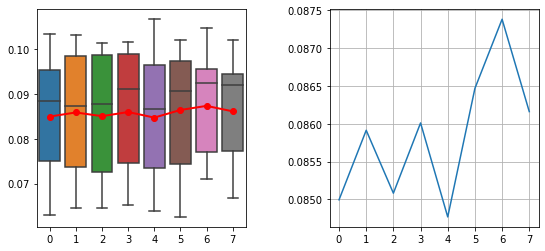

In [126]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
svm_params = np.array([[0.010, 1], [0.015, 1], [0.020, 1], [0.025, 1], 
                       [0.030, 1], [0.035, 1], [0.040, 1], [0.045, 1]])
num_models = len(svm_params)

# print header for the progress bar and initialise variables
prog, prog_last, prog_diff = progress_bar_init(num_reps, num_folds)

# create array of zeros to store rpss values for each model over each rep/fold
svm_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate Support Vector Machines models (rbf kernel)
        for j in range(num_models):
            svm_mod = svm.SVC(kernel='rbf', random_state=1, gamma=svm_params[j,0], C=svm_params[j,0], probability=True)
            svm_rpss[k + rep*num_folds,j] = fit_eval_rpss(svm_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        prog, prog_last, prog_diff = progress_bar(rep, k, num_reps, num_folds, prog, prog_last, prog_diff)

print("\n\nComplete!")

svm_params_opt = list(svm_params[np.argmax(np.mean(svm_rpss, axis=0))])
print("Optimum Support Vector Machines Parameters:", svm_params_opt)  

# plot RPSS results 
plot_rpss(svm_rpss)

---

### - K Nearest Neighbour Models Evaluation

Next, I will look at a non-parameteric method used for classification, K Nearest Neighbours. I will only be tuning 1 hyperparameter when evaluating these models, the number of neighbours (*n_neoghbors*).

Cross-Validation Starting Time = 18:58:51 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 3 reps, 5 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum KNN Parameters: 280
CPU times: user 43.9 s, sys: 611 ms, total: 44.5 s
Wall time: 44.6 s


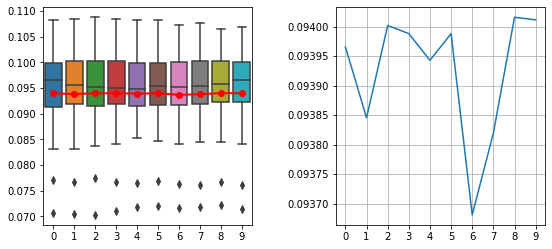

In [127]:
%%time

# set number of reps and folds
num_folds = 5
num_reps = 3

# define list of parameters to trial, and calculate number of models
knn_params = np.array(list(range(200,300,10)))
num_models = len(knn_params)

# print header for the progress bar and initialise variables
prog, prog_last, prog_diff = progress_bar_init(num_reps, num_folds)

# create array of zeros to store rpss values for each model over each rep/fold
knn_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)

    for k in range(num_folds):  # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate KNN models
        for j in range(num_models):
            knn_mod = knn(n_neighbors=knn_params[j])
            knn_rpss[k + rep*num_folds,j] = fit_eval_rpss(knn_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        prog, prog_last, prog_diff = progress_bar(rep, k, num_reps, num_folds, prog, prog_last, prog_diff)

print("\n\nComplete!")

knn_params_opt = knn_params[np.argmax(np.mean(knn_rpss, axis=0))]
print("Optimum KNN Parameters:", knn_params_opt)  

# plot RPSS results 
plot_rpss(knn_rpss)

---

### - Evaluating All Models

Having obtained suitable model parameters for random forest, gradient boosting, SVM and KNN models above, we can compare each of the best observed models along with a number of other models which don't require hyperparameter tuning (Linear Discriminant Analysis, Quadratic Analysis, Logistic Regression) to determine which model performs the best.

This time, we will perform the cross-validation process for a greater number of repetitions and folds. The best overall model will again be determined based on the average Ranked Probability Skill Score value obtained.

Cross-Validation Starting Time = 19:01:02 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 5 reps, 10 folds )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Complete!
Optimum Model: Boosting
CPU times: user 14min, sys: 6.82 s, total: 14min 7s
Wall time: 12min 58s


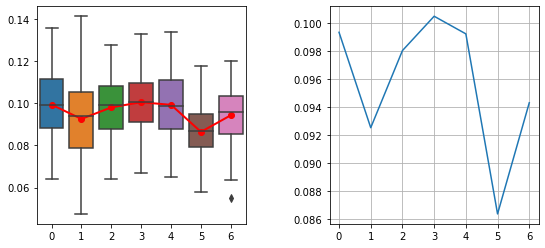

In [128]:
%%time

# set number of reps, folds and models
num_reps = 5
num_folds = 10
num_models = 7

# print header for the progress bar and initialise variables
prog, prog_last, prog_diff = progress_bar_init(num_reps, num_folds)

# create array of zeros to store rpss values
models_rpss = np.zeros(shape=[num_folds*num_reps, num_models])

for rep in range(num_reps): # loop through number of reps specified
    
    # generate list of folds from the full set of training/validation data (randomly shuffled)
    folds = np.array_split(EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5','FTR']].sample(frac=1), num_folds)
    
    for k in range(num_folds): # loop through number of folds specified
        
        # get training and validation sets for the current fold iteration       
        train_x, train_y, val_x, val_y = get_train_val_folds(folds, num_folds, k)

        # fit/evaluate LDA model
        lda_mod = lda()
        models_rpss[k + rep*num_folds,0] = fit_eval_rpss(lda_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate QDA model
        qda_mod = qda()
        models_rpss[k + rep*num_folds,1] = fit_eval_rpss(qda_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate optimum Random Forest model
        rf_mod = rf(n_estimators=rf_params_opt[0], max_depth=rf_params_opt[1], random_state=0)
        models_rpss[k + rep*num_folds,2] = fit_eval_rpss(rf_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate optimum Gradient Boosting model
        boost_mod = boost(n_estimators=boost_params_opt[0], max_depth=boost_params_opt[1], random_state=0)
        models_rpss[k + rep*num_folds,3] = fit_eval_rpss(boost_mod, train_x, train_y, val_x, val_y)

        # fit/evaluate Logistic Regression model
        lr_mod = logreg(random_state=0, max_iter=200)
        models_rpss[k + rep*num_folds,4] = fit_eval_rpss(lr_mod, train_x, train_y, val_x, val_y)
        
        # fit/evaluate optimum SVM model with rbf kernel
        svm_mod = svm.SVC(kernel='rbf', random_state=1, gamma=svm_params_opt[0], C=svm_params_opt[1], probability=True)
        models_rpss[k + rep*num_folds,5] = fit_eval_rpss(svm_mod, train_x, train_y, val_x, val_y)
        
        # fit/evaluate optimum KNN model
        svm_mod = knn(n_neighbors=knn_params_opt)
        models_rpss[k + rep*num_folds,6] = fit_eval_rpss(knn_mod, train_x, train_y, val_x, val_y)

        # update values for progress bar
        prog, prog_last, prog_diff = progress_bar(rep, k, num_reps, num_folds, prog, prog_last, prog_diff)
        
print("\n\nComplete!")

model_list = ["LDA", "QDA", "Random Forest", "Boosting", "Logisitc Regression", "SVM", "KNN"]
print("Optimum Model:", model_list[np.argmax(np.mean(models_rpss, axis=0))])

# plot RPSS results
plot_rpss(models_rpss)

---

### - Fitting the Best Model

From performing cross-validation, the Gradient Boosting model was identified as having the best overall performance. The optimum parameters used for this model have been printed below.

In [129]:
print("Optimum Number of estimators:", boost_params_opt[0],
      "\nOptimum Maximum Depth:", boost_params_opt[1])

Optimum Number of estimators: 150 
Optimum Maximum Depth: 1


Therefore I have chosen to use a Gradient Boosting model for the final model which will be used to predict the probabilites for all simulated fixtures. The full set of data can then be fitted to the final model. The predictor variables are stored in 'xtrain' and the target variable is stored in 'ytrain'.

I have fitted these data to the final model below.

In [130]:
# define full set of training data for fitting the final/best model 
xtrain = EPL[['HomePPCprev', 'AwayPPCprev','HomeForm5','AwayForm5']]
ytrain = EPL['FTR'].values

In [131]:
# fit optimum model to the full set of data
mymodel = boost(n_estimators=boost_params_opt[0], max_depth=boost_params_opt[1], random_state=0)
mymodel.fit(xtrain, ytrain)
print("Final model fitting complete!")

Final model fitting complete!


To demonstrate what probabilities the model predicts for a number of different scenarios, I have created the barplots below. Each shows the predicted probabilities for a home win, draw and away win for a fixture given different combinations of values for the 'PPCprev' and 'Form5' variables.

The first plot shows an example where the home and away teams are given identical 'PPCprev' values and identical 'Form5' values (0.5 in both cases). The fact that the model predicts a higher probability of a home win than an away win indicates that it accounts for home advantage to some extent.

The second and third plots show cases where the 'HomePPCprev' value is greater than the 'AwayPPCprev' value, and vice versa. Comparing to the first plot, it is clear that the probability weightings adjust to improve the win probability of the team with the larger 'PPCprev' value, and reduce the win probability of the other team as a result.

Finally, the last 2 plots show cases where the 'PPCprev' values are the same for both teams, but the 'HomeForm5' value is greater than the 'AwayForm5' value, and vice versa. We see a very similar trend here to the second and third plots, with the probabilities adjusting depending on the relative 'Form5' values.

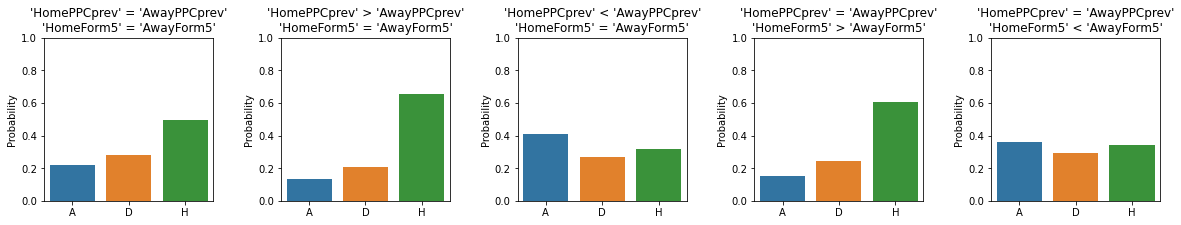

In [132]:
# examples of predicted probabilities
# (output order in the form: [Away Win probability, Draw probability, Home Win Probability])
preds_example1 = list(mymodel.predict_proba(np.array([0.5, 0.5, 0.5, 0.5]).reshape(1, -1)).flatten())
preds_example2 = list(mymodel.predict_proba(np.array([0.6, 0.4, 0.5, 0.5]).reshape(1, -1)).flatten())
preds_example3 = list(mymodel.predict_proba(np.array([0.4, 0.6, 0.5, 0.5]).reshape(1, -1)).flatten())
preds_example4 = list(mymodel.predict_proba(np.array([0.5, 0.5, 0.9, 0.1]).reshape(1, -1)).flatten())
preds_example5 = list(mymodel.predict_proba(np.array([0.5, 0.5, 0.1, 0.9]).reshape(1, -1)).flatten())

# set up plot size
plt.figure(figsize=(20,3))
# increase spaacing between figures
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1 = plt.subplot(151)
plot1 = sns.barplot(mymodel.classes_, preds_example1).set(ylabel="Probability", title="'HomePPCprev' = 'AwayPPCprev'\n'HomeForm5' = 'AwayForm5'", ylim=[0,1])
ax2 = plt.subplot(152)
plot2 = sns.barplot(mymodel.classes_, preds_example2).set(ylabel="Probability", title="'HomePPCprev' > 'AwayPPCprev'\n'HomeForm5' = 'AwayForm5'", ylim=[0,1])
ax3 = plt.subplot(153)
plot3 = sns.barplot(mymodel.classes_, preds_example3).set(ylabel="Probability", title="'HomePPCprev' < 'AwayPPCprev'\n'HomeForm5' = 'AwayForm5'", ylim=[0,1])
ax4 = plt.subplot(154)
plot4 = sns.barplot(mymodel.classes_, preds_example4).set(ylabel="Probability", title="'HomePPCprev' = 'AwayPPCprev'\n'HomeForm5' > 'AwayForm5'", ylim=[0,1])
ax5 = plt.subplot(155)
plot5 = sns.barplot(mymodel.classes_, preds_example5).set(ylabel="Probability", title="'HomePPCprev' = 'AwayPPCprev'\n'HomeForm5' < 'AwayForm5'", ylim=[0,1])


---

# 5. Creating Model to Impute Form Values for Simulated Fixtures

---

### - Analysis of 'HomeForm5' and 'AwayForm5' variables

When imputing missing 'HomeForm5' and 'AwayForm5' values for the original EPL dataframe, I chose to use the 'HomePPC' and 'AwayPPC' variables respectively with ordinal regression models to generate reasonable values. However, these variables will not be available when simulating fixtures for our new data as it won't be possible to determine these values until the end of each simulated season. Therefore new variables must be used.

Looking at the correlation coefficients between the 'PPCprev' and 'Form5' values for the home and away data separately, there appears to be a moderate to strong linear relationship between the variables in both cases. As a result, I have chosen to use these variables when recreating ordinal regression models to impute the unknown home and away form values during fixture simulations, using all of our data during training. These will be used when estimating form values for each team that hasn't played 5 previous fixtures (and it isn't possible to calculate our form metric value as a result).

In [133]:
print("Correlation between PPCprev and Form values (Home):", EPL['HomePPCprev'].corr(EPL['HomeForm5']),
      "\nCorrelation between PPCprev and Form values (Away):", EPL['AwayPPCprev'].corr(EPL['AwayForm5']))

Correlation between PPCprev and Form values (Home): 0.47043146492090415 
Correlation between PPCprev and Form values (Away): 0.47535458567748


---

### - Fitting ordinal regression models for imputing form values

Firstly, I will set up the data for fitting to the ordinal regression models, with 'Form5' values for the y data and 'PPCprev' values for the x data.

In [134]:
home_x_train = EPL[['HomePPCprev']]
home_y_train = EPL['HomeForm5'].values
away_x_train = EPL[['AwayPPCprev']]
away_y_train = EPL['AwayForm5'].values

Next, the target data ('Form5' variables) must be encoded using a label encoder so that they can be used when fitting to the model. And finally, the data can be fitted to ordinal regression models. These trained models will be used later when imputing 'Form5' values where required during simulation of fixtures.

In [135]:
# encode y_train data to only include values from 0 to n categories
home_le = LabelEncoder()
home_le.fit(np.array(home_y_train))
home_y_train2 = home_le.transform(np.array(home_y_train))

away_le = LabelEncoder()
away_le.fit(np.array(away_y_train))
away_y_train2 = home_le.transform(np.array(away_y_train))

In [136]:
# fit training data to ordinal logistic regression model (home form data)
ord_reg_home = mord.LogisticAT()
ord_reg_home.fit(np.array(home_x_train), np.array(home_y_train2))

# fit training data to ordinal logistic regression model (away form data)
ord_reg_away = mord.LogisticAT()
ord_reg_away.fit(np.array(away_x_train), np.array(away_y_train2))
print("Model fitting complete!")

Model fitting complete!


---

# 6. Simulation of Fixtures

---

### - Generating random sets of fixtures

As my model takes the form of the competing teams in each fixture into account when determining probabilities from each possible outcome, the order of fixtures can potentially have a significant impact on the performance of each team across the season. 

If form wasn't taken into account, then the ordering of fixtures would have no impact on the generated probabilities. But take for example a team such as Liverpool playing Manchester City on the final day of the season bidding to win the title. If there previous 5 fixtures were against relatively weak teams, then they will likely win the majority of those games and have a relatively large form value going into the final game, thus improving their probability of winning. However, if they happened to be drawn against 5 teams of a similar level, there is a higher probability that they will lose or draw a number of those games and thus enter the final game of the season with a relatively low form value, and as a result their win probability against Manchester City will be reduced. Therefore, it seems sensible to generate a randomly ordered set of fixtures for the season, rather than using an identical set of fixtures for each season.

In order to achieve this, I have created a function below that generates random set of fixtures given a list of teams. This function is based on a commonly used round-robin tournament scheduling algorithm, which I have modified to ensure that each team will play at home or away no more than twice consectutively during the season. It returns a dataframe containing the full set of fixtures for a single season, including return fixtures.

In [137]:
# function that generates list of fixtures given 
def generate_fixtures(teams, dropbyes=False):
    # randomly shuffle the list of teams
    shuffle(teams)
    
    # create empty dataframes to save fixtures
    myfixtures = pd.DataFrame(columns=['Gameweek', 'HomeTeam', 'AwayTeam'])
    myreturnfixtures = pd.DataFrame(columns=['Gameweek', 'HomeTeam', 'AwayTeam'])

    # get length of teams list
    n = len(teams)
    # if number of teams is odd, append 'Bye' to the list
    if n%2 != 0:
        teams.append('Bye')
        n+=1

    # loop through the first (n-1) game weeks (return fixtures not included)
    for gameweek in range(1, n):
        # loop through all fixtures in this game week
        for i in range(n//2):
            
            # reverse home and away teams every second week
            # (ensures that teams don't play at home (or away) more than 2 weeks in a row)
            if gameweek%2 == 0:
                myfixtures.loc[len(myfixtures)] = [gameweek, teams[i], teams[n - 1 - i]]
            else:
                myfixtures.loc[len(myfixtures)] = [gameweek, teams[n - 1 - i], teams[i]]

        # remove last team in teams list and insert at second position in the list
        teams.insert(1, teams.pop())
    
    # copy fixtures to the return fixtures dataframe, but with gameweek incremented and home/away teams reversed
    myreturnfixtures['Gameweek'] = myfixtures['Gameweek'] + (n - 1)
    myreturnfixtures['HomeTeam'] = myfixtures['AwayTeam']
    myreturnfixtures['AwayTeam'] = myfixtures['HomeTeam']

    if dropbyes==True:
        myfixtures = myfixtures[(myfixtures['HomeTeam']!='Bye') & (myfixtures['AwayTeam']!='Bye')]
        myreturnfixtures = myreturnfixtures[(myreturnfixtures['HomeTeam']!='Bye') & (myreturnfixtures['AwayTeam']!='Bye')]
    
    # return dataframe with original fixtures and return fixtures combined
    return pd.concat([myfixtures, myreturnfixtures]).reset_index(drop=True)

---

### - Stochastic modification of 'PPCprev' values

In order to add variation into the system which will aid to account for major changes that happen to teams between seasons (e.g. a team signs a player that improves the team significantly, or a key player is injured and the team isn't as strong as in the previous year), the 'HomePPCprev' and 'AwayPPCprev' values can also be randomly sampled. A Beta distribution is suitable in this case as it is bounded between 0 and 1 as is required.

In order to sample a 'PPCprev' value for an individual team, we can randomly sample the value from a Beta distribution with a specified variance and with its mode equal to the actual PPCprev value obtained by the team. The mode is preferred to the mean as the beta distribution tends to be skewed significantly when its mean is close to 0 or close to 1. In such cases the median or mode can be a better measure of the centre of the distribution.

Using the mode instead of the median will also reduce the likelihood of teams that achieved an unusually high points total from getting an even larger 'PPCprev' value after sampling from the beta distribution (and likewise for teams that achieved an unusually low number of points).

To calculate the $\alpha$ and $\beta$ parameter values for a Beta distribution with a specified mode and variance, we can use the following equations:

$Mode[X] = \frac{\alpha - 1}{\alpha + \beta - 2}$

$Var[X] = \frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$

Note that this definition of the mode is valid obly when $\alpha$ and $\beta$ in our Beta function are both be greater than 1, which will be the case here.

We can solve for $\alpha$ and $\beta$ in terms of Mode[X] and Var[X], where:

$\beta = (\frac{1 - Mode[X]}{Mode[X]}) \alpha + (\frac{2 Mode[X] - 1}{Mode[X]}) = x \alpha + y$ ........ (i.e. $x = \frac{1 - Mode[X]}{Mode[X]}$ and $y = \frac{2 Mode[X] - 1}{Mode[X]}$)

and where $\alpha$ is obtained by getting the roots of the following cubic equation, and finding the root that is greater than 1 (as this is a constraint of our Beta distribution in this case):

$\alpha ^3 (x^3 + 3x^2 + 3x + 1) + 
\alpha ^2 (x^2 + 2x + 3y + 3x^2y + 6xy + 1 - \frac{x}{Var[X]}) + 
\alpha (3y^2 + 2y + 3xy^2 + 2xy - \frac{y}{Var[X]}) + 
(y^3 + y^2) = 0$  



The function below takes mode and variance values as input arguments, and determines the $\alpha$ and $\beta$ parameters values for a Beta distribution that satisfies these requirements (if such values exist) using the equations above.

In [138]:
# function calculates coefficients for claculating alpha for Beta distribution with specified Mode and Var
def get_beta_coefs(Mode, Var):
    # define x and y to simplify equation
    x = (1 - Mode)/Mode
    y = (2*Mode - 1)/Mode
    # calculate coefficients of cubic equation to solve for alpha value
    a =  (x**3) + 3*(x**2) + 3*x + 1
    b =  (x**2) + 2*x + 3*y + 3*(x**2)*y + 6*x*y + 1 - x/Var
    c =  3*(y**2) + 2*y + 3*x*(y**2) + 2*x*y - y/Var
    d =  (y**3) + (y**2)
    
    # get roots of the cubic equation
    roots = np.roots([a,b,c,d])
    
    # check if a root exists that is >1
    if len(roots[roots>1]) > 0:
        # set alpha to value of the root that is >1
        alpha = roots[roots>1].item()
        # set beta based on alpha
        beta = x * alpha + y
    else:
        # if no root >1, print message to reduce variance
        print("No roots greater than 1 (reduce variance value)")
        alpha = np.nan
        beta = np.nan
        
    return alpha, beta

To visualise the effect of this function, I have generated $\alpha$ and $\beta$ parameter values for the case where the mode is specified as 0.9 and the variance is specified as 0.005. The plot below shows the probability density distribution for values sampled from this Beta distribution, along with the location of the theoretical mode and the mean of the sampled values.

The plot below demonstrates why choosing the mode for the centre of the distribution is preferred to the mean. For this example if we had chosen the mean to be 0.9 then the distribution would have been shifted further to the right, increasing the likelihood of the sampled value being greater than 0.9. As 'PPCprev' values close to 1 (and conversely, values close to 0) are rare and could typically be considered as outliers, using the mean as the center of the distribution could result in values that are already extreme becoming even more extreme, resulting in 'great' teams getting better and better, and 'awful' teams getting worse and worse.

The variance value can then be adjusted to increase or decrease the variance in results.

In [139]:
alpha1, beta1 = get_beta_coefs(0.9,0.004)
alpha1, beta1 

(23.654579364322743, 3.5171754849247483)

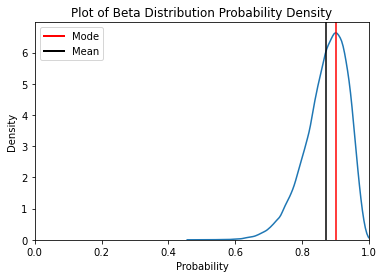

In [141]:
# randomly sample 100000 values from a Beta distribution with the specified parameters
dist = np.random.beta(alpha1, beta1, size=100000)
# create density plot
ax = sns.kdeplot(dist)
# add red line at theoretical mode
plt.axvline(0.9, 0,15, color='r')
# add black line at mean of the distribution values
plt.axvline(np.mean(dist), 0,15, color='black')

# set axes limits, title and axis labels, and add legend
ax.set(xlim=(0,1)); ax.set_xlabel("Probability"); ax.set_ylabel("Density");
ax.set_title("Plot of Beta Distribution Probability Density")
a=ax.legend([Line2D([0], [0], color='r', lw=2), Line2D([0], [0], color='black', lw=2)], ['Mode', 'Mean'])

---

### - Get initial results table for fixture simulations

Before simulating the results in a new season of fixtures, we first need to know the initial 'PPCprev' values for each of the teams in our new season. I have decided to use the teams and corresponding 'PPC' values from the latest season in our given dataset.

In [142]:
# get last seasons finishing table and reset row indices
initial_table = all_seasons_WLD[all_seasons_WLD['Season']==24].copy()
initial_table.reset_index(drop=True, inplace=True)
# set season value to 0 (will be considered )
initial_table['Season'] = 0

# display table
initial_table

,Season,Team,W,D,L,PointsTot,PointsPC
0,0,Liverpool,32,3,3,99,0.868421
1,0,Man City,26,3,9,81,0.710526
2,0,Man United,18,12,8,66,0.578947
3,0,Chelsea,20,6,12,66,0.578947
4,0,Leicester,18,8,12,62,0.54386
5,0,Tottenham,16,11,11,59,0.517544
6,0,Wolves,15,14,9,59,0.517544
7,0,Arsenal,14,14,10,56,0.491228
8,0,Burnley,15,9,14,54,0.473684
9,0,Sheffield United,14,12,12,54,0.473684


---

### - Functions for Simulating Fixtures

To simulate multiple new seasons of fixtures, a number of different tasks need to be performed. These include generating a set of fixtures for each season, simulating individual fixtures based on the form and percentage of points achieved in the previous year for each of the teams, updating the team form values based on results throughout each season and calculating the points earned by each individual team at the end of each season. 

Below, I have broken many of these tasks into individual functions which will be used later when simulating fixtures over multiple seasons.

The first function is introduce some random variation to the 'PPCprev' values obtained by each team using the *get_beta_coefs* function defined earlier. The function takes a dataframe containing each team in the current seasonalong with their 'PPCprev' value obtained in the previous season as an input, as well as a variance value, and returns modified 'PPCprev' values for each team based on their original 'PPCprev' value and the specified level of variance.

In [143]:
def pointspc_beta_sample(df, teams, var):
    # copy 'PointsPC' values to new column - 'PointsPC_actual'
    df['PointsPC_actual'] = df['PointsPC']
    
    # sample 'PointsPCnew' from beta distribution with mode equal to 'PointsPC' value (adds random variation)
    for team in teams:    
        alpha, beta = get_beta_coefs(df.loc[df['Team']==team, 'PointsPC'].item(), var)
        df.loc[df['Team']==team, 'PointsPC'] = np.random.beta(alpha, beta)
        
    return df

The next function generates a season of fixtures using the *generate_fixtures* function defined earlier, and adds further columns to store 'PPCprev' and 'Form5' values for each team, as well as the simulated result. It then adds the appropriate 'PPCprev' values to each fixture based on the values obtained by the teams in their previous season.

In [144]:
def generate_fixtures_dataframe(df, teams):
    # generate season of fixtures based on given list of teams
    newseason = generate_fixtures(teams)
    
    # add columns for PPCprev, form and result and set to 0.0/'' for now
    newseason['HomePPCprev'] = 0.0
    newseason['AwayPPCprev'] = 0.0
    newseason['HomeForm5'] = 0.0
    newseason['AwayForm5'] = 0.0
    newseason['FTRsim'] = ''

    # loop through all fixtures 
    for fixture in range(newseason.shape[0]):
        # add home and away PPCprev values for the teams in the current fixture
        newseason.loc[fixture,'HomePPCprev'] = df[df['Team']==newseason.loc[fixture,'HomeTeam']]['PointsPC'].item()
        newseason.loc[fixture,'AwayPPCprev'] = df[df['Team']==newseason.loc[fixture,'AwayTeam']]['PointsPC'].item()
    
    return newseason

The function below creates a number of dataframes which will be used to store numerous values and statistics for a simulated season, such as the points achieved by each team in each fixture, the form value of each team going into each fixture, and the final points table from the season.

In [145]:
def create_sim_dataframes(teams, season):
    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    teams_WLD.insert(0,"Season",season)

    ## create data frame to store points in each game
    teams_ppg = DataFrame(columns=range(1,39))
    teams_ppg.insert(0,"Team",teams)
    teams_ppg.insert(0,"Season",season)
    
    ## create data frame to store 5 game form
    teams_form = DataFrame(columns=range(1,39))
    teams_form.insert(0,"Team",teams)
    teams_form.insert(0,"Season",season)
    
    return teams_WLD, teams_ppg, teams_form

The next function is used to simulate a full set of fixtures for a single season, looping through each individual fixture and obtaining the current form value for each team (or imputing these values if the teams have not played a sufficient number of games to calculate this yet), generating the probability of each full time result outcome occurring using the optimum model created earlier, and randomly generating the full time result based on these probabilities.

In [152]:
def simulate_current_season(df, teams_form, teams_ppg):
    # loop through all the fixtures in the new season dataframe
    for fixture in range(df.shape[0]):
        # set number of games used in form value calculation
        form_games = 5
        # get names of home and away teams
        hometeam = df.loc[fixture, 'HomeTeam']
        awayteam = df.loc[fixture, 'AwayTeam']
        # get next available game index values for the home and away teams
        home_nextfree = teams_form.columns[(teams_form.loc[teams_form['Team']==hometeam,].isna()).iloc[0]].min()
        away_nextfree = teams_form.columns[(teams_form.loc[teams_form['Team']==awayteam,].isna()).iloc[0]].min()

        # if gameweek <= 5 we will need to impute the form values for each team
        if df.loc[fixture, 'Gameweek'] <= form_games:
            # impute home form value based on HomePPCprev value (sampling from probabilities obtained from ordinal regression)
            df.loc[fixture, 'HomeForm5'] = np.random.choice(form_classes, 1, p=ord_reg_home.predict_proba(np.array(df.loc[fixture, 'HomePPCprev'])).flatten()).item()
            # add form value to next available game in teams_form dataframe
            teams_form.loc[teams_form['Team']==hometeam, home_nextfree] = df.loc[fixture, 'HomeForm5']

            # impute away form value based on AwayPPCprev value (sampling from probabilities obtained from ordinal regression)
            df.loc[fixture, 'AwayForm5'] = np.random.choice(form_classes, 1, p=ord_reg_home.predict_proba(np.array(df.loc[fixture, 'AwayPPCprev'])).flatten()).item()
            # add form value to next available game in new_teams_form dataframe
            teams_form.loc[teams_form['Team']==awayteam, away_nextfree] = df.loc[fixture, 'AwayForm5']

        # else, obtain form value from the form table
        else:
            # calculate form of home team (points in the last 5 games)
            home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-form_games+1):(home_nextfree+1)].values.sum()/(form_games*3.0)
            # add form value to HomeForm5 column for the current fixture
            df.at[fixture, 'HomeForm5'] = home_form5
            # add form value to teams_form dataframe
            teams_form.loc[teams_form['Team']==hometeam, home_nextfree] = home_form5

            # calculate form of away team (points in the last 5 games)
            away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-form_games+1):(away_nextfree+1)].values.sum()/(form_games*3.0)
            # add form value to AwayForm5 column for the current fixture
            df.at[fixture, 'AwayForm5'] = away_form5
            # add form value to new_teams_form dataframe
            teams_form.loc[teams_form['Team']==awayteam, away_nextfree] = away_form5

        # get predicted probabilities for a home win, draw and away win for the current fixture
        FTRprobs = list(mymodel.predict_proba(np.array(list(df.loc[fixture,['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']])).reshape(1, -1)).flatten())
        # sample full time result for the current fixture based off the probabilities
        result = np.random.choice(mymodel.classes_, 1, p=FTRprobs)[0]
        # add simulated result to FTRsim column for the current fixture
        df.at[fixture, 'FTRsim'] = result

        # add points (based on simulated result) to new_teams_ppg dataframe for home and away teams
        if result == 'H':
            teams_ppg.loc[teams_ppg['Team']==hometeam, home_nextfree] = 3.0
            teams_ppg.loc[teams_ppg['Team']==awayteam, away_nextfree] = 0.0
        elif result == 'A':
            teams_ppg.loc[teams_ppg['Team']==hometeam, home_nextfree] = 0.0
            teams_ppg.loc[teams_ppg['Team']==awayteam, away_nextfree] = 3.0
        else:
            teams_ppg.loc[teams_ppg['Team']==hometeam, home_nextfree] = 1.0
            teams_ppg.loc[teams_ppg['Team']==awayteam, away_nextfree] = 1.0
        
    return df, teams_form, teams_ppg

After a season has been simulated, the number of wins, draws, losses and the total number of points earned by each team can be obtained using the function below.

In [147]:
def get_final_points(df, teams_WLD, teams):
    # loop through all teams
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((df["HomeTeam"]==team) & (df["FTRsim"]=='H')) | ((df["AwayTeam"]==team) & (df["FTRsim"]=='A')))
        Ds = sum(((df["HomeTeam"]==team) | (df["AwayTeam"]==team)) & (df["FTRsim"]=='D'))
        Ls = sum(((df["HomeTeam"]==team) & (df["FTRsim"]=='A')) | ((df["AwayTeam"]==team) & (df["FTRsim"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe
        WLD_cols = ['W','D','L','PointsTot','PointsPC']
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]

    # sort by highest points
    teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    teams_WLD.reset_index(drop=True, inplace=True)
    
    return teams_WLD

The following 2 functions are used to evaluate the overall level of variation in the points achieved by teams and the final position of teams between 2 seasons. This will be used later as a method of comparing the variation in the simulated results and in the performance of teams over consecutive seasons with the variation observed in the actual data over the past 25 seasons.

In [165]:
def get_points_diff(df_orig, df_sim, points=True):
    # get list of points achieved by each team in the previous season (ordered by team name)
    orig = df_orig.sort_values(by='Team')
    orig = orig['PointsPC_actual']
    # get list of points achieved by each team in the current season (ordered by team name)
    sim = df_sim.sort_values(by='Team')
    sim = sim['PointsPC']
    
    # if points argument is True, multiply by 38x3 (games x points per win) to convert value to points scale
    if points==True:
        orig = orig*38*3
        sim = sim*38*3
    
    # get absolute difference between the points totals of each team
    #diff = np.abs(orig-sim)
    diff = (orig-sim)**2
    
    #return mean and standard deviation values from the list
    return np.mean(diff), np.std(diff)

In [149]:
def get_pos_diff(df_orig, df_sim, teams):
    # create empty list, length equal to number of teams
    mylist = [0]*len(teams)
    # loop through indices corresponding to each team
    for i in range(len(teams)):
        team = teams[i]
        # get final position of current team in previous season and current season
        orig_pos = df_orig.index[df_orig['Team']==team].item()
        sim_pos = df_sim.index[df_sim['Team']==team].item()
        # add absolute value of difference in final position values to list
        #mylist[i] = np.abs(orig_pos-sim_pos)
        mylist[i] = (orig_pos-sim_pos)**2
    
    #return mean and standard deviation values from the list
    return np.mean(mylist), np.std(mylist)

Finally, this function is used to simulate a specified number of seasons of fixtures using the functions defined above.

In [166]:
def simulate_fixtures(teams_WLD_init, variance=0.0001, num_seasons=1, print_prog = True):
    # copy initial table to new dataframe
    df0 = teams_WLD_init.copy()
    # get list of teams in the initial table
    teams = list(df0['Team'])
    
    # create empty dataframes to save season stats, PPG and form stats for every team for all seasons
    all_seasons_WLD = DataFrame()
    all_seasons_ppg = DataFrame()
    all_seasons_form = DataFrame()
    all_seasons_fixtures = DataFrame()
    all_seasons_ptsdiff_mean = [0]*num_seasons
    all_seasons_ptsdiff_std = [0]*num_seasons
    all_seasons_posdiff_mean = [0]*num_seasons
    all_seasons_posdiff_std = [0]*num_seasons
    
    if print_prog==True:
        print("Simulating", num_seasons, "seasons...\nNumber of seasons simulated:", end="")
    
    # loop through the number of seasons specified
    for season in range(1, (num_seasons+1)):
        
        # sample 'PointsPCnew' from beta distribution with mode equal to 'PointsPC' value
        df0 = pointspc_beta_sample(df0, teams, variance)

        # get dataframe of random fixtures, with 'PPCprev' values added to each team
        newseason = generate_fixtures_dataframe(df0, teams)

        # create dataframes to store total points, points per game and form values per game
        teams_WLD, teams_ppg, teams_form = create_sim_dataframes(teams, season)

        # simulate all fixtures for the given season, imputing and calculating form values as required
        newseason, teams_form, teams_ppg = simulate_current_season(newseason, teams_form, teams_ppg)
        
        # get final points and standings for the simulated season
        teams_WLD = get_final_points(newseason, teams_WLD, teams)

        # get 
        points_diff_mean, points_diff_std = get_points_diff(df0, teams_WLD, points=True)
        pos_diff_mean, pos_diff_std = get_pos_diff(df0, teams_WLD, teams)
        
        # set df0 equal to copy of current season WLD table
        df0 = teams_WLD.copy()
        
        # append current season tables to the multiseason table dataframes
        all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
        all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
        all_seasons_form = all_seasons_form.append(teams_form)
        newseason.insert(0,"Season",season)
        all_seasons_fixtures = all_seasons_fixtures.append(newseason)
        # append points/poistions difference mean and standard deviation values to their respective lists
        all_seasons_ptsdiff_mean[season-1] = points_diff_mean
        all_seasons_ptsdiff_std[season-1] = points_diff_std
        all_seasons_posdiff_mean[season-1] = pos_diff_mean
        all_seasons_posdiff_std[season-1] = pos_diff_std
        
        if print_prog==True:
            print(season, end=" ")
    
    pts_pos_diff = DataFrame(list(zip(all_seasons_ptsdiff_mean, all_seasons_ptsdiff_std, all_seasons_posdiff_mean, all_seasons_posdiff_std)), columns=['PtsDiff_Mean','PtsDiff_Std','PosDiff_Mean','PosDiff_Std'])
    
    if print_prog==True:
        print("Complete!")
    
    return all_seasons_fixtures, all_seasons_WLD, all_seasons_ppg, all_seasons_form, pts_pos_diff

---

### - Simulating multiple seasons

Now we can simulate mulitple seasons of the preimer league using the functions above. Initially, I will use the final table from the premier league from the latest season available to set the initial 'PPCprev' values for each team, and I will simulate 20 seasons.

In [153]:
sim_fixtures, sim_WLD, sim_ppg, sim_form, sim_ptsposdiff = simulate_fixtures(initial_table, variance=0.000001, num_seasons=20)

Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!


Below I have plotted samples from some of the dataframes outputted by the function above.

In [154]:
display(sim_fixtures.head(3))
display(sim_fixtures.tail(3))

,Season,Gameweek,HomeTeam,AwayTeam,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5,FTRsim
0,1,1,Crystal Palace,Man United,0.376776,0.579309,0.066667,0.533333,H
1,1,1,Sheffield United,Man City,0.473258,0.711895,0.000000,1.000000,A
2,1,1,Aston Villa,Newcastle,0.305792,0.386657,0.466667,1.000000,A


,Season,Gameweek,HomeTeam,AwayTeam,HomePPCprev,AwayPPCprev,HomeForm5,AwayForm5,FTRsim
377,20,38,Brighton,Man City,0.438358,0.710070,0.400000,0.400000,H
378,20,38,Norwich,Arsenal,0.483734,0.343312,0.600000,0.400000,A
379,20,38,Tottenham,Sheffield United,0.376454,0.482663,0.466667,0.533333,A


In [155]:
display(sim_WLD.head(3))
display(sim_WLD.tail(3))

,Season,Team,W,D,L,PointsTot,PointsPC
0,1,Liverpool,28,2,8,86,0.754386
1,1,Man City,24,7,7,79,0.692982
2,1,Chelsea,21,8,9,71,0.622807


,Season,Team,W,D,L,PointsTot,PointsPC
17,20,Southampton,11,5,22,38,0.333333
18,20,Man United,10,8,20,38,0.333333
19,20,Watford,8,6,24,30,0.263158


In [156]:
display(sim_ppg.head(3))
display(sim_ppg.tail(3))

,Season,Team,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,1,Man United,0,0,3,3,0,3,0,0,...,3,0,3,3,0,3,0,3,3,0
1,1,Man City,3,1,3,3,3,3,3,3,...,3,3,0,3,3,3,0,1,3,3
2,1,Newcastle,3,0,3,0,3,1,0,0,...,0,1,3,3,0,0,1,1,0,1


,Season,Team,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
17,20,Bournemouth,3,1,3,3,0,3,0,1,...,3,0,0,0,1,0,3,0,0,0
18,20,Chelsea,1,0,0,3,0,0,0,0,...,1,3,3,3,1,0,3,0,3,0
19,20,West Ham,3,1,0,0,0,0,0,1,...,1,0,0,1,3,0,3,1,1,0


---

### - Comparing simulated results to historical results

We can compare the variation in points and positions over consecutive seasons in the simulated data with the equivalent values obtained when looking at the actual data from past seasons of the premier league. Firstly, we can compare our results to a baseline model where teams posistions are picked completely at random each season. Below, I have run 10000 simulations where two lists of the numbers 1 to 20 are randomly shuffled, the mean squared difference in their values is calculated and added to a list. I have then calculated the mean of these values, and then taken the square root so that the value returned is on the same scale as positions. This worst case model resulted in a RMSE values for the positions of just over 8.

In [221]:
pts_dif_sq = [0]*10000
pts_dif_sq_sd = [0]*10000
for i in range(10000):
    pts_listA = list(range(1,21))
    pts_listB = list(range(1,21))
    shuffle(pts_listA)
    shuffle(pts_listB)
    
    pts_dif_sq[i] = np.mean([(a-b)**2 for a,b in zip(pts_listA, pts_listB)])
    pts_dif_sq_sd[i] = np.std([(a-b)**2 for a,b in zip(pts_listA, pts_listB)])

print('RMSE Poisitions Mean:', (np.mean(pts_dif_sq))**0.5)
print('RMSE Poisitions Standard Deviation:', (np.mean(pts_dif_sq_sd))**0.5)

RMSE Poisitions Mean: 8.161999142367021
RMSE Poisitions Standard Deviation: 8.704975168449169


Below, the root mean square difference in points and and final positions for each team over consecutive seasons (in cases where teams featured in the league over consecutive seasons) in the original EPL data (over the past 25 seasons) have been calculated.

In [185]:
diff_list = []
points_diff_list = []

for season in range(24):
    teams0 = all_seasons_WLD[all_seasons_WLD['Season']==season]['Team'].unique()
    teams1 = all_seasons_WLD[all_seasons_WLD['Season']==(season+1)]['Team'].unique()
    for team0 in teams0:
        if team0 in teams1:
            #total_num_teams += 1
            
            points0 = all_seasons_WLD[all_seasons_WLD['Season']==season][(all_seasons_WLD[all_seasons_WLD['Season']==season]['Team']==team0)]['PointsTot'].item()
            points1 = all_seasons_WLD[all_seasons_WLD['Season']==(season+1)][(all_seasons_WLD[all_seasons_WLD['Season']==(season+1)]['Team']==team0)]['PointsTot'].item()
            
            #points_diff_list.append(np.abs(points0-points1))
            points_diff_list.append((points0-points1)**2)
            
            temp0 = all_seasons_WLD[all_seasons_WLD['Season']==season].reset_index(drop=True)
            pos0 = temp0[temp0['Team']==team0].index.item()
            temp1 = all_seasons_WLD[all_seasons_WLD['Season']==(season+1)].reset_index(drop=True)
            pos1 = temp1[temp1['Team']==team0].index.item()
            
            #diff_list.append(np.abs(pos0-pos1))
            diff_list.append((pos0-pos1)**2)

print("RMSE Points Mean:", np.round((np.mean(points_diff_list))**0.5, 3))
print("RMSE Points Std:", np.round((np.std(points_diff_list))**0.5, 3))
print("RMSE Poisitions Mean:", np.round((np.mean(diff_list))**0.5, 3))
print("RMSE Positions Std:", np.round((np.std(diff_list))**0.5, 3))

RMSE Points Mean: 10.725
RMSE Points Std: 14.035
RMSE Poisitions Mean: 4.363
RMSE Positions Std: 5.464


We can compare these values to the points / positions difference figures returned from the *simulate fixtures* function. Below, I have calculated these figures for 2 separate cases where a different level of variance was specified in the model (used to add random variation into the 'PPCprev' values of each team).

In [258]:
sim_fixturesA, sim_WLDA, sim_ppgA, sim_formA, sim_ptsposdiffA = simulate_fixtures(initial_table, variance=0.08, num_seasons=20)
sim_fixturesB, sim_WLDB, sim_ppgB, sim_formB, sim_ptsposdiffB = simulate_fixtures(initial_table, variance=0.01, num_seasons=20)
sim_fixturesC, sim_WLDC, sim_ppgC, sim_formC, sim_ptsposdiffC = simulate_fixtures(initial_table, variance=0.001, num_seasons=20)
sim_fixturesD, sim_WLDD, sim_ppgD, sim_formD, sim_ptsposdiffD = simulate_fixtures(initial_table, variance=0.0001, num_seasons=20)
sim_fixturesE, sim_WLDE, sim_ppgE, sim_formE, sim_ptsposdiffE = simulate_fixtures(initial_table, variance=0.00001, num_seasons=20)
sim_fixturesF, sim_WLDF, sim_ppgF, sim_formF, sim_ptsposdiffF = simulate_fixtures(initial_table, variance=0.000001, num_seasons=20)

Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!
Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!
Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!
Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!
Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!
Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!


In [259]:
(sim_ptsposdiffA.mean())**0.5 # variance=0.08

PtsDiff_Mean    6.700933
PtsDiff_Std     7.173347
PosDiff_Mean    7.975588
PosDiff_Std     8.722027
dtype: float64

In [260]:
(sim_ptsposdiffB.mean())**0.5 # variance=0.01

PtsDiff_Mean    4.463183
PtsDiff_Std     5.372644
PosDiff_Mean    5.703946
PosDiff_Std     6.523512
dtype: float64

In [261]:
(sim_ptsposdiffC.mean())**0.5 # variance=0.001

PtsDiff_Mean    3.768620
PtsDiff_Std     4.834791
PosDiff_Mean    4.522720
PosDiff_Std     5.642787
dtype: float64

In [262]:
(sim_ptsposdiffD.mean())**0.5 # variance=0.0001

PtsDiff_Mean    4.001562
PtsDiff_Std     4.722625
PosDiff_Mean    5.200961
PosDiff_Std     5.868012
dtype: float64

In [263]:
(sim_ptsposdiffE.mean())**0.5 # variance=0.00001

PtsDiff_Mean    4.104875
PtsDiff_Std     5.162025
PosDiff_Mean    4.714870
PosDiff_Std     5.754263
dtype: float64

In [264]:
(sim_ptsposdiffF.mean())**0.5 # variance=0.000001

PtsDiff_Mean    3.841549
PtsDiff_Std     4.623864
PosDiff_Mean    4.455334
PosDiff_Std     5.334240
dtype: float64

We can also look at the average number of points it took to finish in any given position across all seasons of the simulated data, and compare these figures to the historical data. The code below produces a dataframe showing the mean number of points for each finishing position in both the observed data and the simulated data, as well as the difference between the observed and simulated data for each position. 

The differences in points values between the simulated and observed data are in general very small, but the range in the average points values for the observed data is clearly larger. This partly explains the results above which show that the mean points difference for teams between consecutive seasons is larger than the same figure in the simulated data.

In [252]:
# create empty dataframe to store positions/points data
df_positions = DataFrame(index=list(range(1,21)), columns=["Mean Points (Observed)", "Mean Points (Simulated)", "Difference"])

# loop through possible finishing positions
for pos in range(20):
    
    # create empty list to store points of team who finished in given position for each season
    pospts = []
    # loop through all 25 seasons of the observed data
    for sn in range(24):
        # get points of team who finished in currently selected position for the current season, append to list
        pospts.append(all_seasons_WLD[all_seasons_WLD['Season']==sn].iloc[(pos),5])

    # calculate mean points for the observed and simulated data, and difference in the mean points values
    mean_pts_sim = sim_WLD[sim_WLD.index==(pos)]['PointsTot'].mean()
    mean_pts_obs = np.round(np.mean(pospts), 2)
    mean_pts_diff = np.round(np.mean(pospts) - sim_WLD[sim_WLD.index==(pos)]['PointsTot'].mean(), 2)
    
    # add values obtained for current position to the dataframe
    df_positions.iloc[pos,:] = [mean_pts_obs, mean_pts_sim, mean_pts_diff]

df_positions.transpose()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Mean Points (Observed),86.92,80.08,74,68.96,64.62,61.42,57.54,53.83,51.42,49.04,47.5,46.12,44.33,42.71,41.62,39.79,38.25,35.62,32.29,26.38
Mean Points (Simulated),81.9,73.05,67.5,63,60.4,58.6,55.95,53.65,52.3,50.55,49,47.9,46.8,45.45,43.9,42.8,41.1,38.75,36.35,30.8
Difference,5.02,7.03,6.5,5.96,4.23,2.82,1.59,0.18,-0.88,-1.51,-1.5,-1.77,-2.47,-2.74,-2.27,-3.01,-2.85,-3.12,-4.06,-4.43


One other test I wanted to perform was to simulate the 2020/2021 season of the premier league multiple times, based on the final standings from the 2019/2020 season, and compare the league positions of the teams in the simulated data to the actual final standings from the 2020/2021 season.

I have created a table below which lists each of the teams who featured in the 2020/2021 season, in the order of their final league positions. The code then runs for a number of specified repetitions, and in each case simulates a single season of the league (using the 2019/2020 table to determine the 'PPCprev' values for each team) and calculates the the root mean square error between the team positions from the new simulated season and from the actual final positions from the 2020/2021 season.

After all repetitions are complete, the code outputs the table of the simulated season which was closest to the actual observed season (in terms of final league positions), as well as plots showing the distribution of RMSE values, as well as the number of iterations taken to achieve the best season.

Starting Time = 16:07:01 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 10 repetitions )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 16:07:36 
Elapsed Time = 0:00:35.680171

Min. RMSE: 3.2719844670996188 
Number of reps until best season: 7 



,Simulated Season Positions,Actual Season Positions,Absolute Difference (Sim-Act)
0,Chelsea,Man City,3.0
1,Liverpool,Man United,1.0
2,Leicester,Liverpool,2.0
3,Man City,Chelsea,3.0
4,Man United,Leicester,3.0
5,Tottenham,West Ham,1.0
6,Wolves,Tottenham,6.0
7,West Ham,Arsenal,2.0
8,Arsenal,Leeds,1.0
9,Aston Villa,Everton,1.0


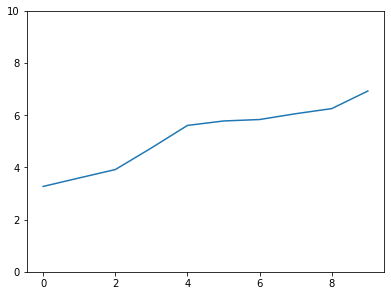

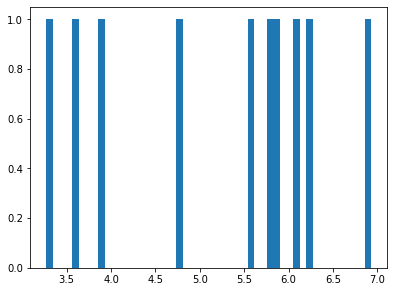

In [590]:
# set seed
np.random.seed(20203868)

# create dataframe of 20 teams from 2020/2021 season, ordered based on their finishing league position
new_table = DataFrame(["Man City", "Man United", "Liverpool", "Chelsea", "Leicester",
           "West Ham", "Tottenham", "Arsenal", "Leeds", "Everton",
           "Aston Villa", "Newcastle", "Wolves", "Crystal Palace", "Southampton",
           "Brighton", "Burnley", "Fulham", "West Brom", "Sheffield United"], columns=["Team"])

# set number of reps to simulate (Note: running time is approx. 1 hour per 1000 reps on my machine)
num_reps = 10

# initialise variables for progress bar
progress = 0; progress_diff = 0; progress_last = 0;

# print starting time
now = datetime.now(); current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time, "\n")
# print header
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_reps, "repetitions )")

# create list to store RMSE value for positions for each repetition (set values to 999 initially)
rmse_avg_list = [999]*num_reps

# loop for specified number of reps
for j in range(num_reps):
    
    # simulate 1 season of EPL, using 2019/2020 season table as initial table
    sim_fixtures1s, sim_WLD1s, sim_ppg1s, sim_form1s, sim_ptsposdiff1s = simulate_fixtures(initial_table, variance=0.000001, num_seasons=1, print_prog=False)

    # create list to store MSE position value for each of the 17 teams (3 newly promoted teams not included)
    mse_list = [999]*17

    # create value to track how many promoted teams have been skipped while looping through the new_table dataframe 
    skip_val=0
    
    # loop through all 20 teams (including newly promoted teams)
    for i in range(20):
        # check that current team is not one of the newly promoted teams
        if new_table['Team'][i] not in ["Leeds", "Fulham", "West Brom"]:
            # calculated squared error in position between initial and new seasons, add to MSE list
            mse_list[i-skip_val] = (sim_WLD1s[sim_WLD1s['Team']==new_table['Team'][i]].index[0]-i)**2
        else:
            # add 1 to skip value (as we have skipped a newly promoted team on this iteration)
            skip_val+=1
    
    # if positions RMSE for the the current season is less than current min RMSE value, set current table as the best table
    if np.sqrt(np.mean(mse_list)) < np.min(rmse_avg_list):
        best_WLD = sim_WLD1s
    
    # add positions RMSE value for the current season to the main list
    rmse_avg_list[j] = np.sqrt(np.mean(mse_list))

    # update values for progress bar
    progress = ((j+1)/(num_reps))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")

# print finishing time and total elapsed time
now2 = datetime.now()
finish_time = now2.strftime("%H:%M:%S")
print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

print("\nMin. RMSE:", min(rmse_avg_list), "\nNumber of reps until best season:", rmse_avg_list.index(min(rmse_avg_list))+1, "\n")
    
# sort the RMSE values from low to high, and plot
plt.plot(np.sort(rmse_avg_list))
plt.ylim(0,10)
# plot histogram of the values
plt.figure()
plt.hist(rmse_avg_list, bins=50)

# add the true order of teams from the 2020/2021 season to a new column of the best table
best_WLD['TrueTeamOrder'] = new_table['Team']

best_WLD['AbsDiff'] = np.nan

for i in best_WLD.index:
    if best_WLD['Team'][i] not in ["Bournemouth", "Norwich", "Watford"]:
        best_WLD.loc[i,'AbsDiff'] = np.abs(i-(best_WLD[best_WLD['TrueTeamOrder']==best_WLD['Team'][i]].index.values[0]))

best_WLD = best_WLD[['Team', 'TrueTeamOrder', 'AbsDiff']].copy()
best_WLD.columns = ['Simulated Season Positions', 'Actual Season Positions', 'Absolute Difference (Sim-Act)']

# print the best table
display(best_WLD)

In [584]:
#rmse_avg_list_2000 = rmse_avg_list.copy()
#best_WLD_2000 = best_WLD.copy()

---

### - Visualising Points and Position Progression over Multiple Simulated Seasons

After simulating a number of seasons using the functions above, we can visualise the progression of points earned by each team across each game and the progression of each team's final league position achieved during each season using appropriate plots.

Firstly, I will simulate 20 seasons worth of fixtures again, using the same initial table as I used previously.

In [388]:
sim_fixtures, sim_WLD, sim_ppg, sim_form, sim_ptsposdiff = simulate_fixtures(initial_table, variance=0.000001, num_seasons=20)

Simulating 20 seasons...
Number of seasons simulated:1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 Complete!


The function below can then be used to plot the points progression of all teams over each game of each season of the simulated data. I have included the option *mean_adjust* which if selected will subtract the mean cumulative points value from each week from all individual values in each gameweek. In the resulting plot, when a team's trend line is increasing it suggests they are earning more points than the average earned points, and when it is decreasing they are earning less points than average.

In [410]:
def plot_points_prog(df_ppg, mean_adjust=False):
    # get number of seasons
    num_seas = df_ppg['Season'].max()
    # create empty list to store points dataframe obtained from each season
    df_list = [0]*num_seas
    
    # loop through each season in the current simulated data
    for i in range(num_seas):
        # get dataframe of points per game data for current season
        df = df_ppg[df_ppg['Season']==(i+1)].copy()
        # order rows by Team name (alphabetically)
        df = df.sort_values('Team')
        # drop Season column and transpose the dataframe
        df = df.drop('Season', axis=1).transpose()
        # set top row (Team names) as the column names, and drop the top row
        df.columns = df.iloc[0]; df = df[1:];
        # add final dataframe to list
        df_list[i] = df
        
    # concatenate all dataframes (1 per season)
    df_pts = pd.concat(df_list)
    # get cumulative sum of points values accross each game of each season
    df_pts = df_pts.cumsum()
    # reset row indices
    df_pts = df_pts.reset_index(drop=True)
    # sort columns by total number of cumulative points
    df_pts = df_pts.T.sort_values(df_pts.index[-1], ascending=False).T
    
    # if mean_adjust parameter is set to true, subtract mean cumulative value at each gameweek from all values
    if mean_adjust==True:
        df_pts = df_pts.sub(df_pts.mean(axis=1), axis=0)
        
    # define list of line colurs (20 specified as the maximum)
    mycolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    # set matplotlib color cycle to first N colours of mycolours (where N is the number of teams specified to be plotted)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours)
    # set figure size parameters
    plt.rcParams["figure.figsize"] = (9,5.75)
    
    # create new plot, plot the data and add a legend
    plt.figure(); df_pts.plot(); plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
     
    # if mean_adjust parameter is set to true, adjust title and axis labels appropriately
    if mean_adjust==True:   
        plt.title('Progression of Cumulative Points for each Team\n(After Subtracting Mean Cumulative Points)')
        plt.xlabel('Game week')
        plt.ylabel('Cumulative Points - Mean')
    else:
        plt.title('Progression of Cumulative Points for each Team')
        plt.xlabel('Game week')
        plt.ylabel('Cumulative Points')
        
    plt.show()
    
    # reset matplotlib color cycle and figure size parameters
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours)
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

<Figure size 648x414 with 0 Axes>

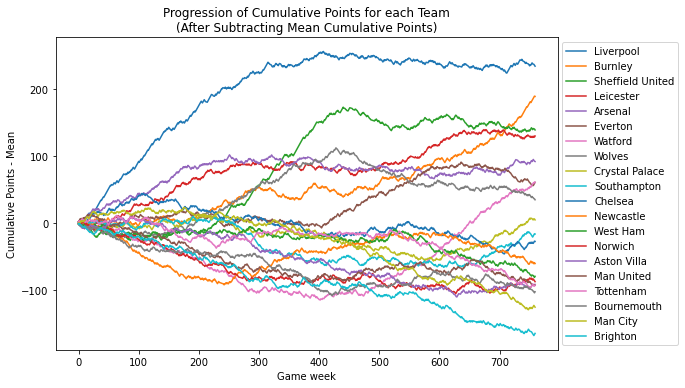

In [411]:
plot_points_prog(sim_ppg, mean_adjust=True)

Likewise, the function below works similarly to the above function, but it plots the cumulative final table position value for each team after each season of the simulated data, and again a *mean_adjust* plotting option is provided.

In [412]:
def plot_pos_prog(df_WLD, mean_adjust=False):
    # get list of teams in the simulated fixtures and order alphabetically
    names = df_WLD['Team'].unique(); names.sort();
    # create dataframe with column for each team
    df=DataFrame(columns=names)
    
    # loop through each season
    for i in range(20):
        # add final position of each team in the current season to the relevant column (i.e. add 1 to row index value)
        df.loc[i,:]=[x+1 for x in list(df_WLD[df_WLD['Season']==(i+1)].sort_values('Team').index)]

    # get cumulative sum of positions after each season
    df = df.cumsum()
    # sort columns from team with lowest final cumulative points to the highest
    df = df.T.sort_values(df.index[-1], ascending=True).T
    
    # if mean adjust is enabled, subtract mean value of each row from the values in each row
    if mean_adjust==True:    
        df = df.sub(df.mean(axis=1), axis=0)
    
    # set figure size parameters
    plt.rcParams["figure.figsize"] = (9,5.75)
    
    # plot the data and add a legend
    plt.figure(); df.plot(); plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    # set xticks ti be integers (corresponding to seasons)
    plt.xticks(range(20))
    # invert axis (lower values correspond to better performance)
    plt.gca().invert_yaxis()
    
    # if mean_adjust parameter is set to true, adjust title and axis labels appropriately
    if mean_adjust==True:   
        plt.title('Progression of Cumulative Positions for each Team\n(After Subtracting Mean Cumulative Points)')
        plt.xlabel('Game week')
        plt.ylabel('Cumulative Position - Mean')
    else:
        plt.title('Progression of Cumulative Positions for each Team')
        plt.xlabel('Game week')
        plt.ylabel('Cumulative Position')
    
    # reset figure size parameters
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
        
    plt.show()

<Figure size 648x414 with 0 Axes>

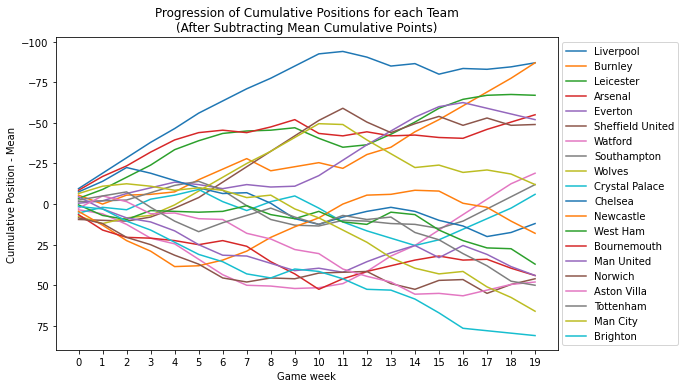

In [413]:
plot_pos_prog(sim_WLD, mean_adjust=True)

---

### - Simulating Multiple Iterations of Multiple Seasons and Visualising the Results

While visualisations of a single set of simulated fixtures over a number of seasons is very insightful, in reality running the simulations again should (and will) lead to vastly different results. In order to visualise the general trends in points and positions progression, I have decided to use a Monte Carlo simulation method whereby I will re-run the multi season simulations a large number of iterations, and in the end I can obtain the mean progression curves for each team.

The first function below runs the simulations for a specified number of seasons and number of overall iterations, and obtains the required points and positions data.

In [393]:
def multi_sim_points_pos_progression(num_runs, num_seas):
    # create empty lists to store positions and points dataframes obtained from each run
    df_list_pos = [0] * num_runs
    df_list_pts = [0] * num_runs

    # initialise variables for progress bar
    progress = 0; progress_diff = 0; progress_last = 0;

    # print starting time
    now = datetime.now(); current_time = now.strftime("%H:%M:%S")
    print("Starting Time =", current_time, "\n")
    # print header
    print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_runs, "runs )")

    # loop through the specified number of runs
    for run in range(num_runs):
        # simulate fixtures for the specified number of seasons
        sim_fixtures, sim_WLD, sim_ppg, sim_form, sim_ptsposdiff = simulate_fixtures(initial_table, variance=0.000001, num_seasons=num_seas, print_prog=False)
        # get list of teams in the simulated fixtures and order alphabetically
        names = sim_WLD['Team'].unique(); names.sort();
        
        
        # Positions Progression
        # ---------------------
        # create dataframe with column for each team
        df_pos = DataFrame(columns=names)
        
        # loop through each season in the current simulated data
        for i in range(0,num_seas):
            # add final position of each team in the current season to the relevant column (i.e. add 1 to row index value)
            df_pos.loc[i,:] = [x+1 for x in list(sim_WLD[sim_WLD['Season']==(i+1)].sort_values('Team').index)]
        
        # get cumulative sum of position values accross each season
        df_pos = df_pos.cumsum()
        # subtract mean value across all teams at every season from the cumulative values
        df_pos = df_pos.sub(df_pos.mean(axis=1), axis=0)
        # add dataframe from the current run to the dataframe list 
        df_list_pos[run] = df_pos
        
        
        # Points Progression
        # ---------------------
        # create list to store points dataframes for each season of each run 
        df_list_pts0 = [0]*num_seas
        
        # loop through each season in the current simulated data
        for i in range(0,num_seas):
            # get dataframe of points per game data for current season
            df_pts0 = sim_ppg[sim_ppg['Season']==(i+1)].copy()
            # order rows by Team name (alphabetically)
            df_pts0 = df_pts0.sort_values('Team')
            # drop Season column and transpose the data
            df_pts0 = df_pts0.drop('Season', axis=1).transpose()
            # set top row (Team names) as the column names, and drop the top row
            df_pts0.columns = df_pts0.iloc[0]; df_pts0 = df_pts0[1:];
            # add final dataframe to list
            df_list_pts0[i] = df_pts0

        # concatenate all dataframes (1 per season) for the current run
        df_pts = pd.concat(df_list_pts0)
        # get cumulative sum of points values accross each game of each season
        df_pts = df_pts.cumsum()
        # reset row indices in the dataframe
        df_pts = df_pts.reset_index(drop=True)
        # subtract mean value across all teams at every game from the cumulative values
        df_pts = df_pts.sub(df_pts.mean(axis=1), axis=0)
        # add dataframe from the current run to the dataframe list 
        df_list_pts[run] = df_pts


        # update values for progress bar
        progress = ((run+1)/(num_runs))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

    # print finishing time and total elapsed time
    now2 = datetime.now()
    finish_time = now2.strftime("%H:%M:%S")
    print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

    # loop through all dataframes in the positions list and create dataframe of total summed values
    df_sum_pos = df_list_pos[0]
    for i in range(1, num_runs):
        df_sum_pos = df_sum_pos + df_list_pos[i]
    # divide summed dataframe by number of runs to get mean values across all runs
    df_mean_pos = df_sum_pos/num_runs
    
    # loop through all dataframes in the points list and create dataframe of total summed values
    df_sum_pts = df_list_pts[0]
    for i in range(1, num_runs):
        df_sum_pts = df_sum_pts + df_list_pts[i]
    # divide summed dataframe by number of runs to get mean values across all runs
    df_mean_pts = df_sum_pts/num_runs
    
    return df_mean_pos, df_list_pos, df_mean_pts, df_list_pts

The following function can then be used to plot either the points progression or else the positions progression curves as required. In either case, the function will plot each the curves from each individual iteration of the simulations but with relatively transparent lines. The mean progression curve for each team will then be displayed in thicker opaque lines.

In [414]:
def plot_multisim_points_pos_prog(df_mean, df_list, points_plot=True, plot_teams=None, transparency=0.2, custom_ylim=None):
    # get copies of the input mean dataframe and dataframes list
    df_mean0 = df_mean.copy(); df_list0 = df_list.copy();
    
    # get order of teams from mean dataframe (from lowest to highest final cumulative position total) 
    # reverse order if points are being plotted rather than positions
    if points_plot==False:
        col_order = (np.argsort([df_mean0.iloc[-1,:]])).flatten().tolist()
    else:
        col_order = (np.argsort([-df_mean0.iloc[-1,:]])).flatten().tolist()

    # reorder columns in mean dataframe
    df_mean0 = df_mean0.iloc[:,col_order]

    # if plot teams list is not specified, set plot teams to list of values from 0 to number_of_teams-1 (i.e. 0 to 19)
    if plot_teams==None:
        plot_teams = list(range(len(col_order)))

    # define list of line colurs (20 specified as the maximum)
    mycolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    # set matplotlib color cycle to first N colours of mycolours (where N is the number of teams specified to be plotted)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours[0:len(plot_teams)])
    # set figure size parameters
    plt.rcParams["figure.figsize"] = (9,5.75)
    
    # plot positions progression from mean dataframe
    df_mean0.iloc[:, plot_teams].plot(alpha=1, linewidth=1.5)

    # loop through number of runs (i.e. length of the dataframe list)
    for i in range(len(df_list)):
        # reorder columns in dataframe for the current run
        df_list0[i] = df_list0[i].iloc[:,col_order]
        # plot positions progression for current dataframe (narrower lines with added transparency)
        plt.plot(df_list0[i].iloc[:,plot_teams], alpha=transparency, linewidth=0.1)

    # add legend outside right hand side of plot
    plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')
    
    if points_plot==False:
        plt.title('Progression of Cumulative Positions for each Team\n(After Subtracting Mean Cumulative Positions)')
        plt.xlabel('Season')
        plt.ylabel('Cumulative Position - Mean')
    else:
        plt.title('Progression of Cumulative Points for each Team\n(After Subtracting Mean Cumulative Points)')
        plt.xlabel('Season')
        plt.ylabel('Cumulative Points - Mean')
    
    # if custom y limits are defined, set y limits of plot
    if custom_ylim!=None:
        plt.ylim(custom_ylim)
    
    # invert y-axis if positions progression is being plotted
    if points_plot==False:
        plt.gca().invert_yaxis()
        
    # reset matplotlib color cycle and figure size parameters
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours)
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    
    # show plot
    plt.show()

Below, I will run 100 iterations of the simulations, simulating 20 seasons in each case, and I will plot the relevant curves below.

In [395]:
df_mean_pos0, df_list_pos0, df_mean_pts0, df_list_pts0 = multi_sim_points_pos_progression(20, 10)

Starting Time = 16:10:32 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 20 runs )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 16:22:32 
Elapsed Time = 0:12:00.071638


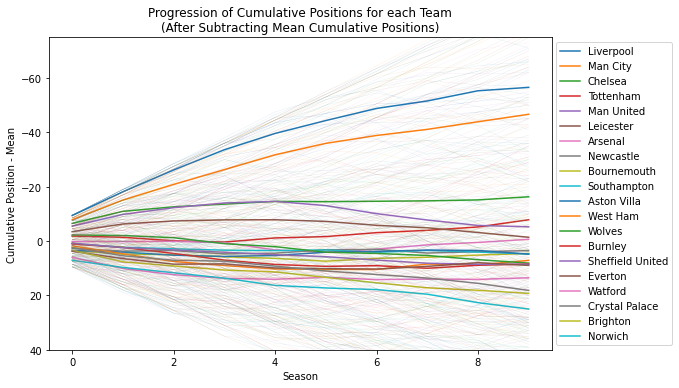

In [440]:
plot_multisim_points_pos_prog(df_mean_pos0, df_list_pos0, points_plot=False, custom_ylim=[-75,40], transparency=0.5)

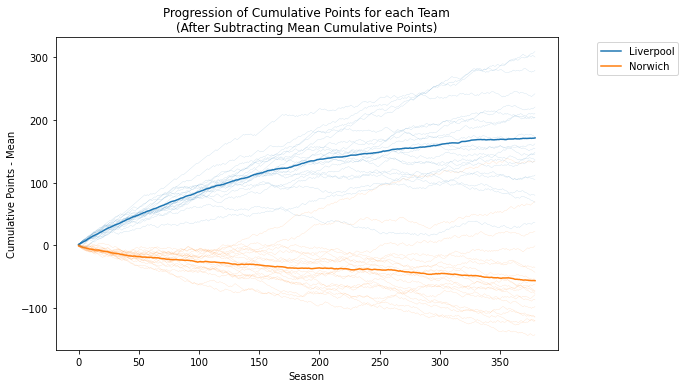

In [420]:
plot_multisim_points_pos_prog(df_mean_pts0, df_list_pts0, points_plot=True, plot_teams=[0,19], transparency=0.8)

---

# 7. Betting Odds

---

### - Simulation of a Simple Betting System

Based on our model used to simulate fixtures over multiple seasons of the premier league, I would now like to simulate a form of betting system where mutiple bets are placed on each outcome of each of our simulated fixtures. Firstly, I will generate betting odds for each fixture based on our fixture prediction model, and will add a margin to ensure that a profit is made.

Next, I will test the profitability of the betting system when the betting odds are generated based on a different model than what was used for generating the actual fixture probabilities, as in reality we won't be able to predict the exact true probabilities of each outcome for each fixture.

Then, I will implement a system where the proportions of bets placed on each outcome will weigh more heavily on average on the "best value" bets (e.g. where the betting probability for a particular outcome underestimates the true probability for that outcome). This will effectively simulate an intelligent market, where (in general) punters may have some additional knowledge or information not condsidered when generating the betting probabilities which leads them to identify when the true probability of an outcome has been underestimated and as a result lead to a larger proportion of bets being made on that outcome.

Finally, I will modify the betting system to review the proportion of bets placed by punters after regular periods, and adjust the betting odds appropriately in each case to better reflect the trends in the market.

Below, I have defined a new model using the k nearest neighbours algorithm as tested earlier. Later we will use this as our model for determining the initial betting probabilities.

In [423]:
mymodel2 = knn(n_neighbors=knn_params_opt)
mymodel2.fit(xtrain, ytrain)
print("Model fitting complete!")

Model fitting complete!


In order to implement the intelligent market functionality described above, I have created the function below which takes the list of actual probabilities and a list of given betting probabilities (with a margin added) and works out potential betting proportions based on an intelligent market (punters know which bets give the best value based on the given betting probabilities and what they believe the true probabilities are).

It uses a softmax function to generate the betting proportions, which are obtained from a dirichlet distribution. We can adjust the level of variance in the outputted probability values from the dirichlet distribution to account for the likelihood that the betting proportions won't be perfectly reflective of the difference between the true probabilities and the given betting probabilities, but overall the market should still follow this general trend.

In [424]:
def get_bet_proportions(true_p, bet_p, C_prob_imbalance=10, C_adjust_var=50, margin=0.05):
    # get adjusted bet probabilities after removing the added margin
    bet_p_adjusted = [(x - margin/3) for x in bet_p]
    
    # bet proportions are based off difference between true probabilities and betting odds (after removing margin)
    # get difference between probability sets and multiply by constant to reduce balance between the probabilities  
    probs_diff = [((a-b) * C_prob_imbalance) for a,b in zip(true_p, bet_p_adjusted)]
    
    # use softmax function to generate probabilities (dirichilet distribution can't take negative values)
    softmax_probs = softmax(probs_diff)
    
    # multiply softmax probabilities by a constant to adjust variance in the outputted values from the dirichilet distribution
    # (variance decreases as conatant increases) 
    softmax_adjusted = [(x * C_adjust_var) for x in softmax_probs]
    
    # generate proportions of bets to be placed on each outcome
    # using adjusted values from the softmax function with a dirichilet distribution
    bet_proportions = np.random.dirichlet(softmax_adjusted, 1).flatten().tolist()
    
    return bet_proportions

We can then perorm Monte Carlo simulation of our betting system to evaluate its profitability. The function below takes a dataframe of simulated fixtures (like what was outputted from our fixture simulation function earlier) as well as a number of other parameters, and simulates the placement of mulitple bets on each outcome of each fixture. 

The distribution of bets can either be set to be balanced (where bets are randomly distributed between each possible outcome), or else they can be based on an intelligent market (where punters will tend to weigh their bets more heavily on outcomes where the given betting odds are better than the true odds). The margin, number of bets per game and betting stake value can also be adjusted.

The function calculates the net profit for each game, and returns a list containing the cumulative sum of the profits (which can also be visulaised on a plot if desired) as well as the overall average profit margin earned.

In [471]:
def betting_sim_basic(df_sim, model_actual, model_betodds, balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_plot=False, show_prog=True):
    # get total number of fixtures
    num_fixtures = df_sim.shape[0]
    
    # get dataframe of true FTR probabilities (used to simulate the fixtures) for each fixture
    probs_actual = DataFrame(model_actual.predict_proba(df_sim[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']]),
                      columns=['P_A_act','P_D_act','P_H_act'])
    
    # get dataframe of FTR probabilities for each fixture based on model for setting betting odds, add margin to all values
    probs_bets = DataFrame(model_betodds.predict_proba(df_sim[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']]),
                      columns=['P_A_odds','P_D_odds','P_H_odds']) + margin/3

    # create empty dataframe to store number of bets placed on each outcome of each fixture
    num_bets = pd.DataFrame(index=range(num_fixtures),columns=['N_A_bets','N_D_bets','N_H_bets'])
    
    # concatenate dataframes to form a single dataframe
    bets_df = pd.concat([probs_actual, probs_bets, num_bets], axis=1)
    # add profit column, set values to 0 initially
    bets_df['Profit'] = 0
    
    # if show progress bar setting is enabled
    if show_prog==True:
        # initialise variables for progress bar
        progress = 0; progress_diff = 0; progress_last = 0;
        # print starting time
        now = datetime.now(); current_time = now.strftime("%H:%M:%S")
        print("Starting Time =", current_time, "\n")
        # print header
        print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                      num_fixtures, "fixtures )")
    
    # loop through all fixtures
    for fix in range(num_fixtures):
        
        # if balanced bets is not enabled, then bet proportions are based off difference between true probabilities and betting odds
        if balanced_bets==False:
            # get actual and betting odds FTR probabilities for the current fixture
            true_probs = bets_df.loc[fix, ['P_A_act','P_D_act','P_H_act']]
            bet_probs = bets_df.loc[fix, ['P_A_odds','P_D_odds','P_H_odds']]
            
            # get bet proportions based on our predicted probabilities and current betting odds
            bet_proportions = get_bet_proportions(true_probs, bet_probs, C_prob_imbalance=10, C_adjust_var=50, margin=margin)
            
        else:
            # if balanced bets is True, generate proportions of bets using even probabilities with a dirichilet distribution
            bet_proportions = np.random.dirichlet([10, 10, 10], 1).flatten().tolist()
        
        # randomly sample where bets will be placed based on bet proportions
        bets = np.random.choice(mymodel.classes_, size=bets_per_game, p=bet_proportions)
        
        # add total number of bets on each outcome to the main dataframe
        bets_df.loc[fix, 'N_A_bets'] = (bets=='A').sum()
        bets_df.loc[fix, 'N_D_bets'] = (bets=='D').sum()
        bets_df.loc[fix, 'N_H_bets'] = (bets=='H').sum()

        # get the simulated result for the current fixture
        result = df_sim.iloc[fix,:]['FTRsim']
        # if result is an away win, calculate net profit based on number of bets placed and given odds for away win
        if result == 'A':
            bets_df.loc[fix, 'Profit'] = (bets_per_game - bets_df.loc[fix, 'N_A_bets'] * (1/bets_df.loc[fix, 'P_A_odds'])) * stake
        # if result is a draw, calculate net profit based on number of bets placed and given odds for draw
        elif result == 'D':
            bets_df.loc[fix, 'Profit'] = (bets_per_game - bets_df.loc[fix, 'N_D_bets'] * (1/bets_df.loc[fix, 'P_D_odds'])) * stake
        # if result is a home win, calculate net profit based on number of bets placed and given odds for home win
        else:
            bets_df.loc[fix, 'Profit'] = (bets_per_game - bets_df.loc[fix, 'N_H_bets'] * (1/bets_df.loc[fix, 'P_H_odds'])) * stake
        
        # if show progress bar setting is enabled
        if show_prog==True:
            # update values for progress bar (% of fixtures that betting simulations have been completed for)
            progress = ((fix+1)/(num_fixtures))*100
            progress_diff = np.floor(progress - progress_last).astype(int)
            progress_last = progress_last + progress_diff
            # print bars corresponding to current progress
            for i in range(progress_diff):
                print("|", end="")

    # if show progress bar setting is enabled
    if show_prog==True:
        # print finishing time and total elapsed time
        now2 = datetime.now()
        finish_time = now2.strftime("%H:%M:%S")
        print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

    # calculate vector of cumulative profit (in millions)
    profit_cumsum = bets_df['Profit'].cumsum()/1000000
    
    # calulate final profit margin (final cumulative profit divided by num. games, num. bets per game, and bet stake)
    final_profit_margin = bets_df['Profit'].cumsum().iloc[-1] / bets_df.shape[0] / bets_per_game / stake
    
    if show_plot==True:
        # set figure size parameters
        plt.rcParams["figure.figsize"] = (9,5.75)
        # plot cumulative profit value across all games, add title and axis labels
        a=plt.plot(profit_cumsum)
        a=plt.title('Net Profit (in Millions)'); a=plt.xlabel('Gameweek'); a=plt.ylabel('Profit (1,000,000 euro)');
        # reset figure size parameters to default
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    
    return profit_cumsum, bets_df, final_profit_margin

Below, I have run betting simulations for a number of different cases to compare the profitability in each case, using the same set of simulated fixtures in each case (over 20 seasons). For all simulations, I have set the margin at 0.05, the stake at 10 euro, and I will place 1000 bets on each game.

- The first simulation uses the balanced proportion of bets approach, and also uses the same model for generating the bet probabilities as what was used to generate the actual probabilities used in the simulation of the fixtures.
- The second simulation uses the same balanced approach, but it uses a different model to generate the betting odds as what was used to generate the actual probabilities used when simulating the fixtures.
- The third model uses the intelligent market approach, where proportion of bets will generally weigh heavier towards outcomes where the betting odds are better than the true probabilitites, and the same model used for generating the actual fixture probabilitites will be used to generate the betting odds.
- Finally, the fourth simulation will also use the intelligent market approach for determining the proportions of bets placed on each outcome, and a different model will be used to generate the betting odds than what was used to generate the fixture probabilities.

0.04457047839036969
0.03911785414699028
0.04921730654348024
0.0012991427514492061


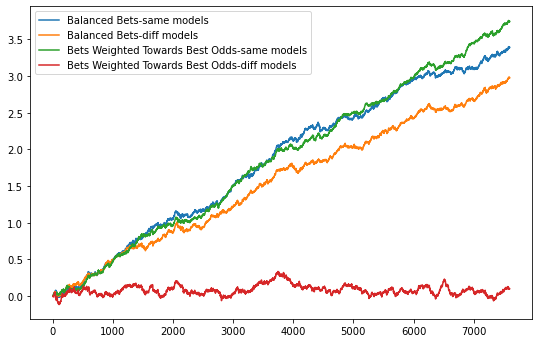

In [470]:
# run 1st simulation, print the average profit margin
cumsum_profits1, bets_df1, final_margin1 = betting_sim_basic(sim_fixtures, mymodel, mymodel, 
                                    balanced_bets=True, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
print("Simulation 1 complete. Average Margin:", final_margin1)

# run 2nd simulation, print the average profit margin
cumsum_profits2, bets_df2, final_margin2 = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                    balanced_bets=True, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
print("Simulation 2 complete. Average Margin:", final_margin2)

# run 3rd simulation, print the average profit margin
cumsum_profits3, bets_df3, final_margin3 = betting_sim_basic(sim_fixtures, mymodel, mymodel, 
                                    balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
print("Simulation 3 complete. Average Margin:", final_margin3)

# run 4th simulation, print the average profit margin
cumsum_profits4, bets_df4, final_margin4 = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                    balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
print("Simulation 4 complete. Average Margin:", final_margin4)

# set figure size parameters
plt.rcParams["figure.figsize"] = (9,5.75)

# plot cumulative profits for each simulation
plt.plot(cumsum_profits1, label='Balanced bets - same models')
plt.plot(cumsum_profits2, label='Balanced bets - different models')
plt.plot(cumsum_profits3, label='Intelligent market - same models')
plt.plot(cumsum_profits4, label='Intelligent market - different models')
a=plt.legend()

# reset figure size parameters to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

---

### - Simulation of a Betting System which Monitors the Distribution of Bets

The function below effectively performs the opposite function of the softmax function used to generate the betting proportions in the function above. It looks at the proportion of bets that were placed on each outcome, and generates 3 values which sum to zero, and which can be summed with the current betting probabilities to adjust them to move closer towards the true probabilities (assuming that the betting proportions reflect which odds were nearest to / furthest from the true probabilities). 

In [427]:
def get_inv_softmax(bets, C_prob_imbalance=10):
    
    # get proportion of bets made on each outcome (ensures each class has at least 1 bet to avoid issues with log(0) later)
    bet_prop = [((bets=='A').sum()+1) / (len(bets)+3), 
                ((bets=='D').sum()+1) / (len(bets)+3), 
                ((bets=='H').sum()+1) / (len(bets)+3)]
    
    # get log of bet_prop values
    inv_soft = np.log(bet_prop)
    
    # divide each value by a constant relating to imbalance in probabilities 
    inv_soft = [(x / C_prob_imbalance) for x in inv_soft]
    # subtract mean from all values so output values sum to 0 (so that the margin is not changed)    
    inv_soft = [(x - np.mean(inv_soft)) for x in inv_soft]
    
    return inv_soft

We can then create a final betting simulation function which works very similarly to the simulation function above, but it also monitors the proportion of bets placed on each outcome over a set number of regular periods and modifies the betting odds to reflect the attitude of the market.

In [459]:
def betting_sim_final(df_sim, model_actual, model_betodds, margin=0.05, stake=10, num_periods=5, bets_per_period=200, show_plot=False, show_prog=True):
    # get total number of fixtures
    num_fixtures = df_sim.shape[0]
    
    # get dataframe of true FTR probabilities (used to simulate the fixtures) for each fixture
    probs_actual = DataFrame(model_actual.predict_proba(df_sim[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']]),
                      columns=['P_A_act','P_D_act','P_H_act'])
    
    # get dataframe of FTR probabilities for each fixture based on model for setting betting odds, add margin to all values
    probs_bets = DataFrame(model_betodds.predict_proba(df_sim[['HomePPCprev', 'AwayPPCprev', 'HomeForm5', 'AwayForm5']]),
                      columns=['P_A_odds','P_D_odds','P_H_odds']) + margin/3

    # create empty dataframe to store number of bets placed on each outcome of each fixture
    num_bets = pd.DataFrame(index=range(num_fixtures),columns=['N_A_bets','N_D_bets','N_H_bets'])
    
    # concatenate dataframes to form a single dataframe
    bets_df = pd.concat([probs_actual, probs_bets, num_bets], axis=1)
    
    # if show progress bar setting is enabled
    if show_prog==True:
        # initialise variables for progress bar
        progress = 0; progress_diff = 0; progress_last = 0;
        # print starting time
        now = datetime.now(); current_time = now.strftime("%H:%M:%S")
        print("Starting Time =", current_time, "\n")
        # print header
        print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                      num_fixtures, "fixtures )")
    
    # get list of profit column names (one for each period and one for total net profit)
    profit_cols = np.append([("Profit"+str(x)) for x in range(num_periods)], "TotalProfit")
    # create empty dataframe to store profit values after each period and total profit, for each fixture
    profit_df = DataFrame(index=range(bets_df.shape[0]), columns=profit_cols)
    
    # loop through all fixtures
    for fix in range(num_fixtures):
    
        # get initial actual and betting odds FTR probabilities for the current fixture
        true_probs = bets_df.loc[fix, ['P_A_act','P_D_act','P_H_act']]
        bet_probs = bets_df.loc[fix, ['P_A_odds','P_D_odds','P_H_odds']]
        
        # loop through each review period
        for p in range(num_periods):
            
            # get bet proportions based on our predicted probabilities and current betting odds
            bet_proportions = get_bet_proportions(true_probs, bet_probs, C_prob_imbalance=10, C_adjust_var=50, margin=margin)

            # randomly sample where bets will be placed based on bet proportions
            bets = np.random.choice(mymodel.classes_, size=bets_per_period, p=bet_proportions)

            # add total number of bets on each outcome to the main dataframe
            bets_df.loc[fix, 'N_A_bets'] = (bets=='A').sum()
            bets_df.loc[fix, 'N_D_bets'] = (bets=='D').sum()
            bets_df.loc[fix, 'N_H_bets'] = (bets=='H').sum()

            # get the simulated result for the current fixture
            result = df_sim.iloc[fix,:]['FTRsim']
            # if result is an away win, calculate net profit based on number of bets placed and given odds for away win
            if result == 'A':
                profit_df.loc[fix, profit_cols[p]] = (bets_per_period - bets_df.loc[fix, 'N_A_bets'] * (1/bet_probs[0])) * stake
            # if result is a draw, calculate net profit based on number of bets placed and given odds for draw
            elif result == 'D':
                profit_df.loc[fix, profit_cols[p]] = (bets_per_period - bets_df.loc[fix, 'N_D_bets'] * (1/bet_probs[1])) * stake
            # if result is a home win, calculate net profit based on number of bets placed and given odds for home win
            else:
                profit_df.loc[fix, profit_cols[p]] = (bets_per_period - bets_df.loc[fix, 'N_H_bets'] * (1/bet_probs[2])) * stake
                
            
            # based on proportion of placed bets, use inverse softmax function to estimate values to update probabilities by
            prob_updates = get_inv_softmax(bets, C_prob_imbalance=25)
        
            # modify betting probabilities 
            bet_probs = [(a+b) for a,b in zip(bet_probs, prob_updates)]
            
            # check for negative probability values
            for i in list(range(3)):
                # if probability is < than 0.02 (i.e. 50/1 odds)
                if bet_probs[i] < 0.02:
                    
                    # set its value minus 0.02 as the minimum value
                    minval = bet_probs[i]-0.02
                    # set the current probability value to 0.02
                    bet_probs[i] = 0.02
                    # get indices of remaining probabilities (i.e. from the list [0,1,2])
                    other_inds = [x for x in list(range(3)) if x not in [i]]
                
                    # if remaining bet probabilities are all geater than the minus the min value over 2, then add minval over 2 to both 
                    if all(x > (-minval/2) for x in list(np.array(bet_probs)[other_inds])):
                        bet_probs[other_inds[0]] = bet_probs[other_inds[0]] + minval/2
                        bet_probs[other_inds[1]] = bet_probs[other_inds[1]] + minval/2
                    # else if the first probabilitiy (not including the currently selected one) is > minus the minvalue, then add minval to this probability 
                    elif bet_probs[other_inds[0]] > (-minval):
                        bet_probs[other_inds[0]] = bet_probs[other_inds[0]] + minval
                    # else the final probability is the largest, and we add minval to this
                    else:
                        bet_probs[other_inds[1]] = bet_probs[other_inds[1]] + minval
            
            # check for probability values greater than 1
            for i in list(range(3)):
                # if probability is > than 0.999
                if bet_probs[i] > 0.999:
                    
                    # set its value minus 0.999 as the max value
                    maxval = bet_probs[i]-0.999
                    # set the current probability value to 0.999
                    bet_probs[i] = 0.999
                    # get indices of remaining probabilities (i.e. from the list [0,1,2])
                    other_inds = [x for x in list(range(3)) if x not in [i]]
                
                    # add maxval over 2 to both remaining probabilities
                    bet_probs[other_inds[0]] = bet_probs[other_inds[0]] + maxval/2
                    bet_probs[other_inds[1]] = bet_probs[other_inds[1]] + maxval/2
                    
            
        # if show progress bar setting is enabled
        if show_prog==True:
            # update values for progress bar (% of fixtures that betting simulations have been completed for)
            progress = ((fix+1)/(num_fixtures))*100
            progress_diff = np.floor(progress - progress_last).astype(int)
            progress_last = progress_last + progress_diff
            # print bars corresponding to current progress
            for i in range(progress_diff):
                print("|", end="")

    # if show progress bar setting is enabled
    if show_prog==True:
        # print finishing time and total elapsed time
        now2 = datetime.now()
        finish_time = now2.strftime("%H:%M:%S")
        print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

    # calculate total profit by summing profits over each period
    profit_df['TotalProfit'] = profit_df.iloc[:,:-1].sum(axis=1)
    # get cumulative sums of profits for each period and for total profit, and divide by 1'000'000 so profit is in millions
    profit_df = profit_df.cumsum() / 1000000

    # create list of total cumulative profit (in millions)
    profit_cumsum = profit_df['TotalProfit'].values.tolist()
    
    if show_plot==True:
        # plot cumulative profit value across all games, add title and axis labels
        a=plt.plot(profit_cumsum)
        a=plt.title('Net Profit (in Millions)'); a=plt.xlabel('Gameweek'); a=plt.ylabel('Profit (1,000,000 euro)');
        
    # calulate final profit margin (final cumulative profit divided by num. games, num. bets per game, and bet stake)
    final_profit_margin = profit_cumsum[-1] / len(profit_cumsum) / (num_periods*bets_per_period) / stake * 1000000
    
    return profit_cumsum, bets_df, profit_df, final_profit_margin

We can now run Monte Carlo simulations to compare betting systems where the betting odds remain static and where they are adjusted periodically to reflect the betting trends in the market.

Starting Time = 17:11:24 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 7600 fixtures )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 17:11:47 
Elapsed Time = 0:00:22.775571
0.0017475796071196258
Starting Time = 17:11:48 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 7600 fixtures )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 17:12:58 
Elapsed Time = 0:01:10.368406
0.032093905249962106


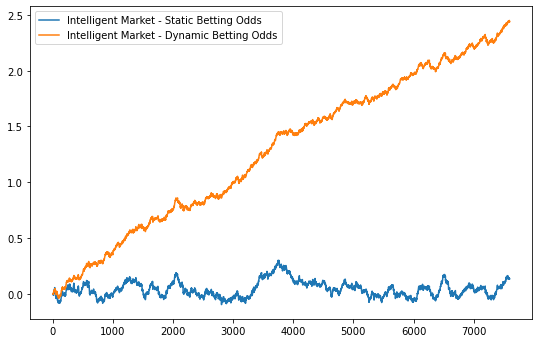

<Figure size 648x414 with 0 Axes>

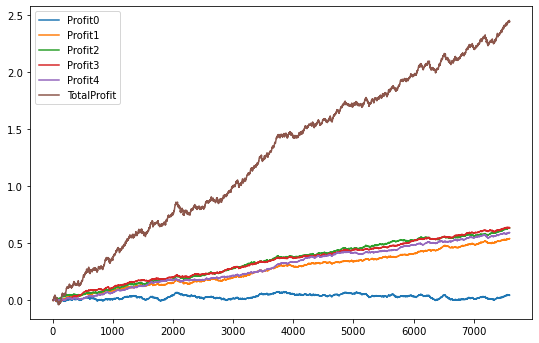

In [463]:
# run 1st simulation, print the average profit margin
cumsum_profits5, bets_df5, final_margin5 = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                    balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=True)
print(final_margin5)

# run 2nd simulation, print the average profit margin
cumsum_profits6, bets_df6, profit_df6, final_margin6 = betting_sim_final(sim_fixtures, mymodel, mymodel2, 
                                    margin=0.05, stake=10, num_periods=5, bets_per_period=200, show_prog=True)
print(final_margin6)

# set figure size parameters
plt.rcParams["figure.figsize"] = (9,5.75)

# plot cumulative profits for each simulation
plt.plot(cumsum_profits5, label='Intelligent Market - Static Betting Odds')
plt.plot(cumsum_profits6, label='Intelligent Market - Dynamic Betting Odds')
a=plt.legend()

plt.figure()
profit_df6.plot()

# restore default figure size parameters
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

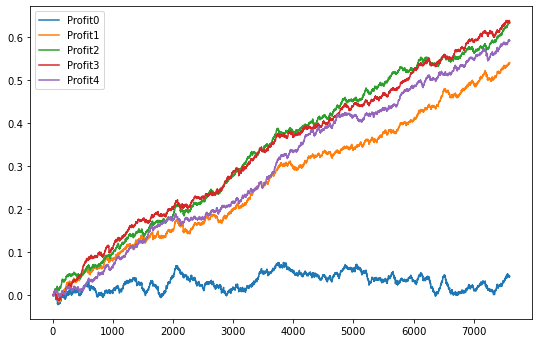

In [464]:
# set figure size parameters
plt.rcParams["figure.figsize"] = (9,5.75)
profit_df6.iloc[:,:-1].plot()
# restore default figure size parameters
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

---

### - Assessing Profitability with a 'Bad' Betting Odds Model

If we consider using an even worse model to predict the outcome probabilities used to set our betting odds, we can still continue to make a profit if we continue to monitor the betting trends of the market and adjust our odds appropriately. Below, I have fitted a second K nearest neighbours model but with far fewer neighbours than the optimum value considered on this occasion (100). This will be used to generate the initial betting odds in the following simulations.

In [460]:
mymodel3 = knn(n_neighbors=100)
mymodel3.fit(xtrain, ytrain)
print("Bad model fitting complete!")

Bad model fitting complete!


We can now repeat the same steps used previously but with the new model used to generate the betting odds, and the equivalent plots will be produced once again.

Starting Time = 17:12:59 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 7600 fixtures )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 17:13:20 
Elapsed Time = 0:00:21.289159
-0.04450869650004014
Starting Time = 17:13:20 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 7600 fixtures )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 17:14:33 
Elapsed Time = 0:01:12.738067
0.016577854056795845


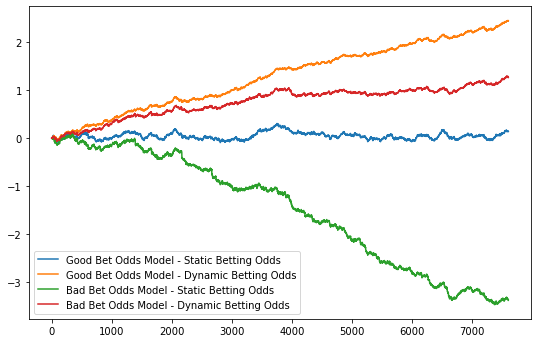

<Figure size 648x414 with 0 Axes>

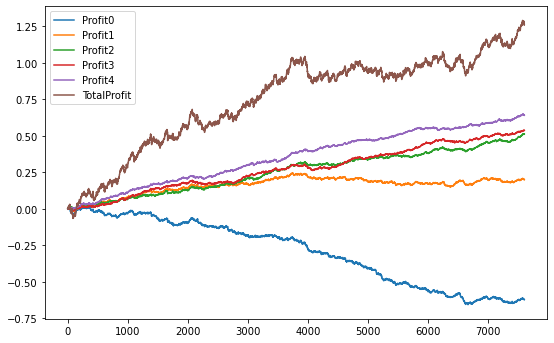

In [465]:
# run 1st simulation, print the average profit margin
cumsum_profits7, bets_df7, final_margin7 = betting_sim_basic(sim_fixtures, mymodel, mymodel3, 
                                    balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=True)
print(final_margin7)

# run 2nd simulation, print the average profit margin
cumsum_profits8, bets_df8, profit_df8, final_margin8 = betting_sim_final(sim_fixtures, mymodel, mymodel3, 
                                    margin=0.05, stake=10, num_periods=5, bets_per_period=200, show_prog=True)
print(final_margin8)

# set figure size parameters
plt.rcParams["figure.figsize"] = (9,5.75)

# plot cumulative profits for each simulation
plt.plot(cumsum_profits5, label='Good Bet Odds Model - Static Betting Odds')
plt.plot(cumsum_profits6, label='Good Bet Odds Model - Dynamic Betting Odds')
plt.plot(cumsum_profits7, label='Bad Bet Odds Model - Static Betting Odds')
plt.plot(cumsum_profits8, label='Bad Bet Odds Model - Dynamic Betting Odds')
a=plt.legend()

plt.figure()
profit_df8.plot()

# restore default figure size parameters
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

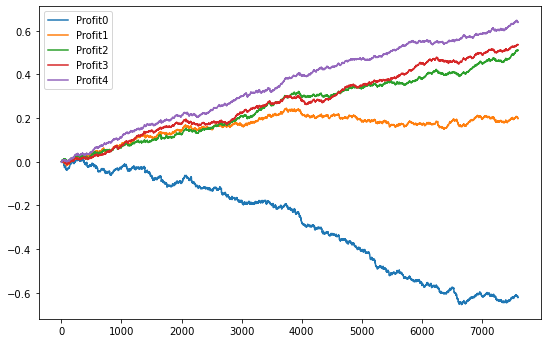

In [466]:
# set figure size parameters
plt.rcParams["figure.figsize"] = (9,5.75)
profit_df8.iloc[:,:-1].plot()
# restore default figure size parameters
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

---

### - Simulating Multiple Iterations of Multiple Seasons and Assessing Betting Profitability

In order to make a better assessment of the profitability of different betting systems, we can test them over multiple iteration and over multiple different sets of fixtures. The function below simulates a specified number of different sets of fixtures (with a specified number of seasons) and for each set of fixtures it tests 3 different betting systems over multiple iterations. The 3 systems that I will simulate are:

1. Simple system with balanced distribution of bets, and odds remain static
2. Intelligent market system, where the market tends to place more bets on 'better value' outcomes, and odds remain static
3. Intelligent market system, where the market tends to place more bets on 'better value' outcomes, and odds are dynamic and react to trends in the market.

The function outputs a list of dataframes containing the cumulative profit values for each betting system over each run, as well as a dataframe containing the mean cumulative profit values for each system over all of the simulated runs.

In [526]:
def multi_sim_bet_profit(num_fixture_sims, num_runs, num_seas):
    # create empty list to store profitability dataframes obtained from each run
    df_list = [0] * num_fixture_sims * num_runs

    # initialise variables for progress bar
    progress = 0; progress_diff = 0; progress_last = 0;

    # print starting time
    now = datetime.now(); current_time = now.strftime("%H:%M:%S")
    print("Starting Time =", current_time, "\n")
    # print header
    print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_fixture_sims*num_runs, "iterations )")

    # loop through the specified number of fixture simulations
    for i in range(num_fixture_sims):
        # simulate a new set of fixtures for the specified number of seasons
        sim_fixtures, sim_WLD, sim_ppg, sim_form, sim_ptsposdiff = simulate_fixtures(initial_table, variance=0.000001, num_seasons=num_seas, print_prog=False)
        
        # loop through number of runs to be performed for each new set of simulated fixtures
        for run in range(num_runs):
            # create list of names of the strategies to be simulated
            names = ['Balanced_Betting', 'Smart_Market_Static_Odds', 'Smart_Market_Dynamic_Odds']

            # create dataframe with column for each strategy
            df_prof = DataFrame(index=list(range(sim_fixtures.shape[0])), columns=names)

            # get cumulative probability values for strategy A (Balanced Bets), add to 1st column of dataframe
            cumsum_profitsA, bets_dfA, final_marginA = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                        balanced_bets=True, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
            df_prof['Balanced_Betting'] = cumsum_profitsA

            # get cumulative probability values for strategy B (Intelligent Market - Dynamic Odds), add to 2nd column of dataframe
            cumsum_profitsB, bets_dfB, final_marginB = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                        balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
            df_prof['Smart_Market_Static_Odds'] = cumsum_profitsB

            # get cumulative probability values for strategy C (Intelligent Market - Static Odds), add to 3rd column of dataframe
            cumsum_profitsC, bets_dfC, profit_dfC, final_marginC = betting_sim_final(sim_fixtures, mymodel, mymodel2, 
                                        margin=0.05, stake=10, num_periods=5, bets_per_period=200, show_prog=False)
            df_prof['Smart_Market_Dynamic_Odds'] = cumsum_profitsC
            
            # add dataframe from the current run to the dataframe list 
            df_list[i*num_runs + run] = df_prof

            # update values for progress bar
            progress = ((i*num_runs + run + 1)/(num_runs*num_fixture_sims))*100
            progress_diff = np.floor(progress - progress_last).astype(int)
            progress_last = progress_last + progress_diff
            # print bars corresponding to current progress
            for j in range(progress_diff):
                print("|", end="")

    # print finishing time and total elapsed time
    now2 = datetime.now()
    finish_time = now2.strftime("%H:%M:%S")
    print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

    # loop through all dataframes in the positions list and create dataframe of total summed values
    df_sum = df_list[0]
    for k in range(1, num_runs):
        df_sum = df_sum + df_list[j]
    # divide summed dataframe by number of runs to get mean values across all runs
    df_mean = df_sum/num_runs
    
    return df_mean, df_list

The following function takes the mean dataframe and list of dataframes outputted by the function above, and plots the data. 

In [527]:
def plot_multisim_points_pos_prog(df_mean, df_list, transparency=0.2, custom_ylim=None):
    # get copies of the input mean dataframe and dataframes list
    df_mean0 = df_mean.copy(); df_list0 = df_list.copy();
    
    col_order = (np.argsort([-df_mean0.iloc[-1,:]])).flatten().tolist()

    # reorder columns in mean dataframe
    df_mean0 = df_mean0.iloc[:,col_order]

    # define list of line colurs (20 specified as the maximum)
    mycolours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
                 '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    # set matplotlib color cycle to mycolours
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours[0:3])
    # set figure size parameters
    plt.rcParams["figure.figsize"] = (9,5.75)
    
    # plot profit curves from mean dataframe
    df_mean0.plot(alpha=1, linewidth=1.5)

    # loop through number of runs (i.e. length of the dataframe list)
    for i in range(len(df_list)):
        # reorder columns in dataframe for the current run
        df_list0[i] = df_list0[i].iloc[:,col_order]
        # plot positions progression for current dataframe (narrower lines with added transparency)
        plt.plot(df_list0[i], alpha=transparency, linewidth=0.1)

    # add legend outside right hand side of plot
    plt.legend()
    
    plt.title('Cumulative Profit for Different Betting Systems')
    plt.xlabel('Gameweek')
    plt.ylabel('Cumulative Profit')

    
    # if custom y limits are defined, set y limits of plot
    if custom_ylim!=None:
        plt.ylim(custom_ylim)
     
    # reset figure size parameters and colour cycle parameters to default
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mycolours)
    
    # show plot
    plt.show()

We will now simulate 20 different set of fixtures over 10 seasons, and simulate betting using each of our 3 systems 5 separate times for each set of fixtures.

In [528]:
df_profit_mean, df_profit_list = multi_sim_bet_profit(10,5,10)

Starting Time = 18:48:17 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 50 iterations )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 19:33:12 
Elapsed Time = 0:44:54.404299


The resulting plots showing the progression of the individual and cumulative profit plots for each of the 3 tested betting systems are displayed below.

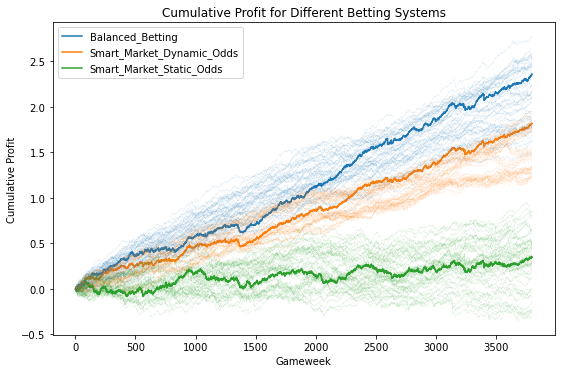

In [529]:
plot_multisim_points_pos_prog(df_profit_mean, df_profit_list, transparency=0.5, custom_ylim=None)

I have also printed the average profit margin earned for each betting system during the simulations, as well as the mean final profit achieved by each system.

In [540]:
display("Average Profit Margin", df_profit_mean.tail(1)/df_profit_mean.shape[0]*1000000/1000/10)
print("")
display("Final Profit (in millions)",df_profit_mean.tail(1))

'Average Profit Margin'

,Balanced_Betting,Smart_Market_Static_Odds,Smart_Market_Dynamic_Odds
3799,0.062124,0.009064,0.047841


'Final Profit (in millions)'

,Balanced_Betting,Smart_Market_Static_Odds,Smart_Market_Dynamic_Odds
3799,2.360726,0.344451,1.817952


# ______________________________

---

# - Reference

Starting Time = 16:28:50 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 20000 repetitions )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 11:53:18 
Elapsed Time = 19:24:27.924775

Min. RMSE: 1.9402850002906638 
Number of reps until best season: 15701 



,Simulated Season Positions,Actual Season Positions,Absolute Difference (Sim-Act)
0,Man City,Man City,0.0
1,Man United,Man United,0.0
2,Liverpool,Liverpool,0.0
3,Chelsea,Chelsea,0.0
4,Arsenal,Leicester,3.0
5,Leicester,West Ham,1.0
6,Everton,Tottenham,3.0
7,Tottenham,Arsenal,1.0
8,West Ham,Leeds,3.0
9,Bournemouth,Everton,NaN


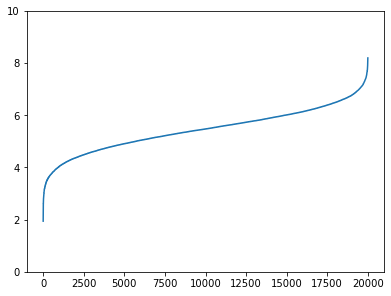

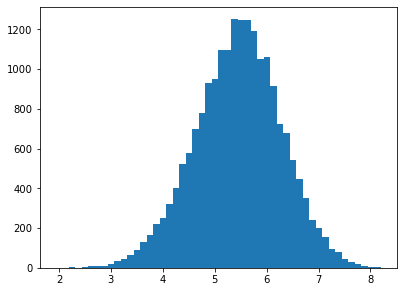

In [568]:
# create dataframe of 20 teams from 2020/2021 season, ordered based on their finishing league position
new_table = DataFrame(["Man City", "Man United", "Liverpool", "Chelsea", "Leicester",
           "West Ham", "Tottenham", "Arsenal", "Leeds", "Everton",
           "Aston Villa", "Newcastle", "Wolves", "Crystal Palace", "Southampton",
           "Brighton", "Burnley", "Fulham", "West Brom", "Sheffield United"], columns=["Team"])

# set number of reps to simulate (Note: running time is approx. 1 hour per 1000 reps on my machine)
num_reps = 20000

# initialise variables for progress bar
progress = 0; progress_diff = 0; progress_last = 0;

# print starting time
now = datetime.now(); current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time, "\n")
# print header
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_reps, "repetitions )")

# create list to store RMSE value for positions for each repetition (set values to 999 initially)
rmse_avg_list = [999]*num_reps

# loop for specified number of reps
for j in range(num_reps):
    
    # simulate 1 season of EPL, using 2019/2020 season table as initial table
    sim_fixtures1s, sim_WLD1s, sim_ppg1s, sim_form1s, sim_ptsposdiff1s = simulate_fixtures(initial_table, variance=0.000001, num_seasons=1, print_prog=False)

    # create list to store MSE position value for each of the 17 teams (3 newly promoted teams not included)
    mse_list = [999]*17

    # create value to track how many promoted teams have been skipped while looping through the new_table dataframe 
    skip_val=0
    
    # loop through all 20 teams (including newly promoted teams)
    for i in range(20):
        # check that current team is not one of the newly promoted teams
        if new_table['Team'][i] not in ["Leeds", "Fulham", "West Brom"]:
            # calculated squared error in position between initial and new seasons, add to MSE list
            mse_list[i-skip_val] = (sim_WLD1s[sim_WLD1s['Team']==new_table['Team'][i]].index[0]-i)**2
        else:
            # add 1 to skip value (as we have skipped a newly promoted team on this iteration)
            skip_val+=1
    
    # if positions RMSE for the the current season is less than current min RMSE value, set current table as the best table
    if np.sqrt(np.mean(mse_list)) < np.min(rmse_avg_list):
        best_WLD = sim_WLD1s
    
    # add positions RMSE value for the current season to the main list
    rmse_avg_list[j] = np.sqrt(np.mean(mse_list))

    # update values for progress bar
    progress = ((j+1)/(num_reps))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")

# print finishing time and total elapsed time
now2 = datetime.now()
finish_time = now2.strftime("%H:%M:%S")
print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

print("\nMin. RMSE:", min(rmse_avg_list), "\nNumber of reps until best season:", rmse_avg_list.index(min(rmse_avg_list))+1, "\n")
    
# sort the RMSE values from low to high, and plot
plt.plot(np.sort(rmse_avg_list))
plt.ylim(0,10)
# plot histogram of the values
plt.figure()
plt.hist(rmse_avg_list, bins=50)

# add the true order of teams from the 2020/2021 season to a new column of the best table
best_WLD['TrueTeamOrder'] = new_table['Team']

best_WLD['AbsDiff'] = np.nan

for i in best_WLD.index:
    if best_WLD['Team'][i] not in ["Bournemouth", "Norwich", "Watford"]:
        best_WLD.loc[i,'AbsDiff'] = np.abs(i-(best_WLD[best_WLD['TrueTeamOrder']==best_WLD['Team'][i]].index.values[0]))

best_WLD = best_WLD[['Team', 'TrueTeamOrder', 'AbsDiff']].copy()
best_WLD.columns = ['Simulated Season Positions', 'Actual Season Positions', 'Absolute Difference (Sim-Act)']

# print the best table
display(best_WLD)

Starting Time = 14:06:01 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 2000 repetitions )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 16:02:25 
Elapsed Time = 1:56:23.658330

Min. RMSE: 2.497057091387191 
Number of reps until best season: 1787 



,Simulated Season Positions,Actual Season Positions,Absolute Difference (Sim-Act)
0,Man City,Man City,0.0
1,Man United,Man United,0.0
2,Liverpool,Liverpool,0.0
3,Chelsea,Chelsea,0.0
4,Arsenal,Leicester,3.0
5,Tottenham,West Ham,1.0
6,Leicester,Tottenham,2.0
7,West Ham,Arsenal,2.0
8,Everton,Leeds,1.0
9,Wolves,Everton,3.0


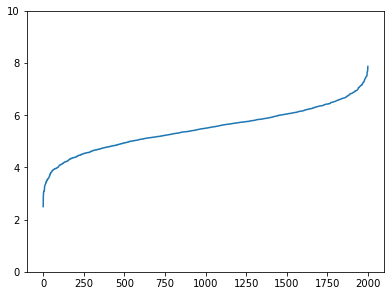

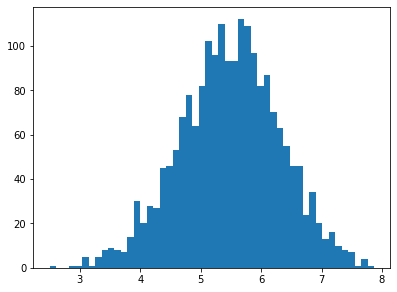

In [567]:
# create dataframe of 20 teams from 2020/2021 season, ordered based on their finishing league position
new_table = DataFrame(["Man City", "Man United", "Liverpool", "Chelsea", "Leicester",
           "West Ham", "Tottenham", "Arsenal", "Leeds", "Everton",
           "Aston Villa", "Newcastle", "Wolves", "Crystal Palace", "Southampton",
           "Brighton", "Burnley", "Fulham", "West Brom", "Sheffield United"], columns=["Team"])

# set number of reps to simulate (Note: running time is approx. 1 hour per 1000 reps on my machine)
num_reps = 2000

# initialise variables for progress bar
progress = 0; progress_diff = 0; progress_last = 0;

# print starting time
now = datetime.now(); current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time, "\n")
# print header
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_reps, "repetitions )")

# create list to store RMSE value for positions for each repetition (set values to 999 initially)
rmse_avg_list = [999]*num_reps

# loop for specified number of reps
for j in range(num_reps):
    
    # simulate 1 season of EPL, using 2019/2020 season table as initial table
    sim_fixtures1s, sim_WLD1s, sim_ppg1s, sim_form1s, sim_ptsposdiff1s = simulate_fixtures(initial_table, variance=0.000001, num_seasons=1, print_prog=False)

    # create list to store MSE position value for each of the 17 teams (3 newly promoted teams not included)
    mse_list = [999]*17

    # create value to track how many promoted teams have been skipped while looping through the new_table dataframe 
    skip_val=0
    
    # loop through all 20 teams (including newly promoted teams)
    for i in range(20):
        # check that current team is not one of the newly promoted teams
        if new_table['Team'][i] not in ["Leeds", "Fulham", "West Brom"]:
            # calculated squared error in position between initial and new seasons, add to MSE list
            mse_list[i-skip_val] = (sim_WLD1s[sim_WLD1s['Team']==new_table['Team'][i]].index[0]-i)**2
        else:
            # add 1 to skip value (as we have skipped a newly promoted team on this iteration)
            skip_val+=1
    
    # if positions RMSE for the the current season is less than current min RMSE value, set current table as the best table
    if np.sqrt(np.mean(mse_list)) < np.min(rmse_avg_list):
        best_WLD = sim_WLD1s
    
    # add positions RMSE value for the current season to the main list
    rmse_avg_list[j] = np.sqrt(np.mean(mse_list))

    # update values for progress bar
    progress = ((j+1)/(num_reps))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")

# print finishing time and total elapsed time
now2 = datetime.now()
finish_time = now2.strftime("%H:%M:%S")
print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

print("\nMin. RMSE:", min(rmse_avg_list), "\nNumber of reps until best season:", rmse_avg_list.index(min(rmse_avg_list))+1, "\n")
    
# sort the RMSE values from low to high, and plot
plt.plot(np.sort(rmse_avg_list))
plt.ylim(0,10)
# plot histogram of the values
plt.figure()
plt.hist(rmse_avg_list, bins=50)

# add the true order of teams from the 2020/2021 season to a new column of the best table
best_WLD['TrueTeamOrder'] = new_table['Team']

best_WLD['AbsDiff'] = np.nan

for i in best_WLD.index:
    if best_WLD['Team'][i] not in ["Bournemouth", "Norwich", "Watford"]:
        best_WLD.loc[i,'AbsDiff'] = np.abs(i-(best_WLD[best_WLD['TrueTeamOrder']==best_WLD['Team'][i]].index.values[0]))

best_WLD = best_WLD[['Team', 'TrueTeamOrder', 'AbsDiff']].copy()
best_WLD.columns = ['Simulated Season Positions', 'Actual Season Positions', 'Absolute Difference (Sim-Act)']

# print the best table
display(best_WLD)

Starting Time = 12:04:36 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 2000 repetitions )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 14:06:00 
Elapsed Time = 2:01:23.207644

Min. RMSE: 2.7224556389190906 
Number of reps until best season: 1652 



,Simulated Season Positions,Actual Season Positions,Absolute Difference (Sim-Act)
0,Liverpool,Man City,2.0
1,Man City,Man United,1.0
2,Leicester,Liverpool,2.0
3,Arsenal,Chelsea,4.0
4,Chelsea,Leicester,1.0
5,Man United,West Ham,4.0
6,Tottenham,Tottenham,0.0
7,Norwich,Arsenal,NaN
8,West Ham,Leeds,3.0
9,Aston Villa,Everton,1.0


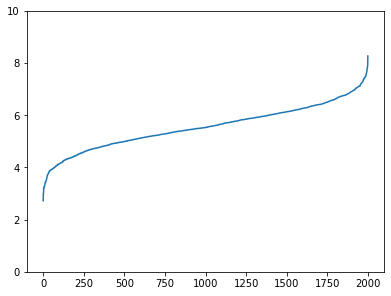

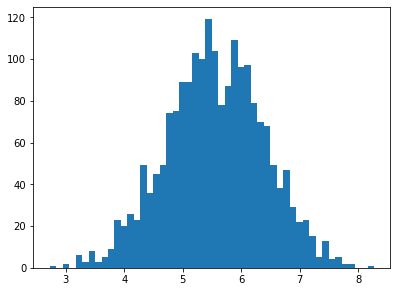

In [566]:
# create dataframe of 20 teams from 2020/2021 season, ordered based on their finishing league position
new_table = DataFrame(["Man City", "Man United", "Liverpool", "Chelsea", "Leicester",
           "West Ham", "Tottenham", "Arsenal", "Leeds", "Everton",
           "Aston Villa", "Newcastle", "Wolves", "Crystal Palace", "Southampton",
           "Brighton", "Burnley", "Fulham", "West Brom", "Sheffield United"], columns=["Team"])

# set number of reps to simulate (Note: running time is approx. 1 hour per 1000 reps on my machine)
num_reps = 2000

# initialise variables for progress bar
progress = 0; progress_diff = 0; progress_last = 0;

# print starting time
now = datetime.now(); current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time, "\n")
# print header
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_reps, "repetitions )")

# create list to store RMSE value for positions for each repetition (set values to 999 initially)
rmse_avg_list = [999]*num_reps

# loop for specified number of reps
for j in range(num_reps):
    
    # simulate 1 season of EPL, using 2019/2020 season table as initial table
    sim_fixtures1s, sim_WLD1s, sim_ppg1s, sim_form1s, sim_ptsposdiff1s = simulate_fixtures(initial_table, variance=0.0001, num_seasons=1, print_prog=False)

    # create list to store MSE position value for each of the 17 teams (3 newly promoted teams not included)
    mse_list = [999]*17

    # create value to track how many promoted teams have been skipped while looping through the new_table dataframe 
    skip_val=0
    
    # loop through all 20 teams (including newly promoted teams)
    for i in range(20):
        # check that current team is not one of the newly promoted teams
        if new_table['Team'][i] not in ["Leeds", "Fulham", "West Brom"]:
            # calculated squared error in position between initial and new seasons, add to MSE list
            mse_list[i-skip_val] = (sim_WLD1s[sim_WLD1s['Team']==new_table['Team'][i]].index[0]-i)**2
        else:
            # add 1 to skip value (as we have skipped a newly promoted team on this iteration)
            skip_val+=1
    
    # if positions RMSE for the the current season is less than current min RMSE value, set current table as the best table
    if np.sqrt(np.mean(mse_list)) < np.min(rmse_avg_list):
        best_WLD = sim_WLD1s
    
    # add positions RMSE value for the current season to the main list
    rmse_avg_list[j] = np.sqrt(np.mean(mse_list))

    # update values for progress bar
    progress = ((j+1)/(num_reps))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")

# print finishing time and total elapsed time
now2 = datetime.now()
finish_time = now2.strftime("%H:%M:%S")
print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

print("\nMin. RMSE:", min(rmse_avg_list), "\nNumber of reps until best season:", rmse_avg_list.index(min(rmse_avg_list))+1, "\n")
    
# sort the RMSE values from low to high, and plot
plt.plot(np.sort(rmse_avg_list))
plt.ylim(0,10)
# plot histogram of the values
plt.figure()
plt.hist(rmse_avg_list, bins=50)

# add the true order of teams from the 2020/2021 season to a new column of the best table
best_WLD['TrueTeamOrder'] = new_table['Team']

best_WLD['AbsDiff'] = np.nan

for i in best_WLD.index:
    if best_WLD['Team'][i] not in ["Bournemouth", "Norwich", "Watford"]:
        best_WLD.loc[i,'AbsDiff'] = np.abs(i-(best_WLD[best_WLD['TrueTeamOrder']==best_WLD['Team'][i]].index.values[0]))

best_WLD = best_WLD[['Team', 'TrueTeamOrder', 'AbsDiff']].copy()
best_WLD.columns = ['Simulated Season Positions', 'Actual Season Positions', 'Absolute Difference (Sim-Act)']

# print the best table
display(best_WLD)

Starting Time = 19:52:37 

|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % ( 15000 repetitions )
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Finishing Time = 10:37:12 
Elapsed Time = 14:44:35.126361

Min. RMSE: 2.14201664188625 
Number of reps until best season: 851 



,Team,TrueTeamOrder
0,Liverpool,Man City
1,Man City,Man United
2,Man United,Liverpool
3,West Ham,Chelsea
4,Chelsea,Leicester
5,Leicester,West Ham
6,Tottenham,Tottenham
7,Bournemouth,Arsenal
8,Wolves,Leeds
9,Newcastle,Everton


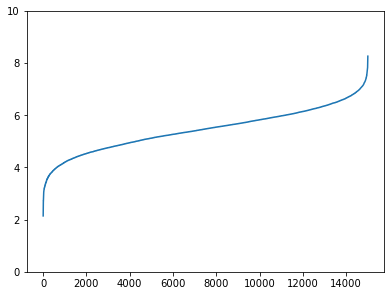

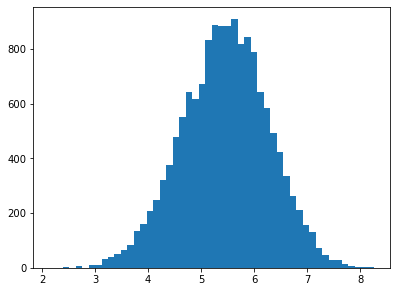

In [541]:
# create dataframe of 20 teams from 2020/2021 season, ordered based on their finishing league position
new_table = DataFrame(["Man City", "Man United", "Liverpool", "Chelsea", "Leicester",
           "West Ham", "Tottenham", "Arsenal", "Leeds", "Everton",
           "Aston Villa", "Newcastle", "Wolves", "Crystal Palace", "Southampton",
           "Brighton", "Burnley", "Fulham", "West Brom", "Sheffield United"], columns=["Team"])

# set number of reps to simulate (Note: running time is approx. 1 hour per 1000 reps on my machine)
num_reps = 15000

# initialise variables for progress bar
progress = 0; progress_diff = 0; progress_last = 0;

# print starting time
now = datetime.now(); current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time, "\n")
# print header
print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_reps, "repetitions )")

# create list to store RMSE value for positions for each repetition (set values to 999 initially)
rmse_avg_list = [999]*num_reps

# loop for specified number of reps
for j in range(num_reps):
    
    # simulate 1 season of EPL, using 2019/2020 season table as initial table
    sim_fixtures1s, sim_WLD1s, sim_ppg1s, sim_form1s, sim_ptsposdiff1s = simulate_fixtures(initial_table, variance=0.000001, num_seasons=1, print_prog=False)

    # create list to store MSE position value for each of the 17 teams (3 newly promoted teams not included)
    mse_list = [999]*17

    # create value to track how many promoted teams have been skipped while looping through the new_table dataframe 
    skip_val=0
    
    # loop through all 20 teams (including newly promoted teams)
    for i in range(20):
        # check that current team is not one of the newly promoted teams
        if new_table['Team'][i] not in ["Leeds", "Fulham", "West Brom"]:
            # calculated squared error in position between initial and new seasons, add to MSE list
            mse_list[i-skip_val] = (sim_WLD1s[sim_WLD1s['Team']==new_table['Team'][i]].index[0]-i)**2
        else:
            # add 1 to skip value (as we have skipped a newly promoted team on this iteration)
            skip_val+=1
    
    # if positions RMSE for the the current season is less than current min RMSE value, set current table as the best table
    if np.sqrt(np.mean(mse_list)) < np.min(rmse_avg_list):
        best_WLD = sim_WLD1s
    
    # add positions RMSE value for the current season to the main list
    rmse_avg_list[j] = np.sqrt(np.mean(mse_list))

    # update values for progress bar
    progress = ((j+1)/(num_reps))*100
    progress_diff = np.floor(progress - progress_last).astype(int)
    progress_last = progress_last + progress_diff
    # print bars corresponding to current progress
    for i in range(progress_diff):
        print("|", end="")

# print finishing time and total elapsed time
now2 = datetime.now()
finish_time = now2.strftime("%H:%M:%S")
print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

print("\nMin. RMSE:", min(rmse_avg_list), "\nNumber of reps until best season:", rmse_avg_list.index(min(rmse_avg_list))+1, "\n")
    
# sort the RMSE values from low to high, and plot
plt.plot(np.sort(rmse_avg_list))
plt.ylim(0,10)
# plot histogram of the values
plt.figure()
plt.hist(rmse_avg_list, bins=50)

# add the true order of teams from the 2020/2021 season to a new column of the best table
best_WLD['TrueTeamOrder'] = new_table['Team']

# print the Team and TrueTeamOrder columns from the best table
display(best_WLD[['Team', 'TrueTeamOrder']])

(0.0, 1.0)

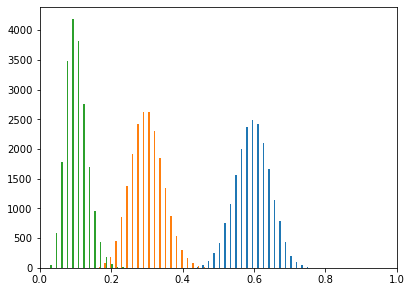

In [456]:
plt.hist(np.random.dirichlet((60,30,10), 20000), bins=50)
plt.xlim([0,1])

In [477]:
def multi_sim_bet_profit(num_runs, num_seas):
    # create empty list to store profitability dataframes obtained from each run
    df_list = [0] * num_runs

    # initialise variables for progress bar
    progress = 0; progress_diff = 0; progress_last = 0;

    # print starting time
    now = datetime.now(); current_time = now.strftime("%H:%M:%S")
    print("Starting Time =", current_time, "\n")
    # print header
    print("|________._________.___2|5___._________.________5|0________._________.___7|5___._________._________| % (",
                  num_runs, "runs )")

    # loop through the specified number of runs
    for run in range(num_runs):
        # simulate fixtures for the specified number of seasons
        sim_fixtures, sim_WLD, sim_ppg, sim_form, sim_ptsposdiff = simulate_fixtures(initial_table, variance=0.000001, num_seasons=num_seas, print_prog=False)
        
        # create list of names of the strategies to be simulated
        names = ['Balanced_Betting', 'Smart_Market_Static_Odds', 'Smart_Market_Dynamic_Odds']
        
        # create dataframe with column for each strategy
        df_prof = DataFrame(index=list(range(sim_fixtures.shape[0])), columns=names)
        
        # get cumulative probability values for strategy A (Balanced Bets), add to 1st column of dataframe
        cumsum_profitsA, bets_dfA, final_marginA = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                    balanced_bets=True, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
        df_prof['Balanced_Betting'] = cumsum_profitsA
        
        # get cumulative probability values for strategy B (Intelligent Market - Dynamic Odds), add to 2nd column of dataframe
        cumsum_profitsB, bets_dfB, final_marginB = betting_sim_basic(sim_fixtures, mymodel, mymodel2, 
                                    balanced_bets=False, margin=0.05, stake=10, bets_per_game=1000, show_prog=False)
        df_prof['Smart_Market_Static_Odds'] = cumsum_profitsB
        
        # get cumulative probability values for strategy C (Intelligent Market - Static Odds), add to 3rd column of dataframe
        cumsum_profitsC, bets_dfC, profit_dfC, final_marginC = betting_sim_final(sim_fixtures, mymodel, mymodel2, 
                                    margin=0.05, stake=10, num_periods=5, bets_per_period=200, show_prog=False)
        df_prof['Smart_Market_Dynamic_Odds'] = cumsum_profitsC


        # add dataframe from the current run to the dataframe list 
        df_list[run] = df_prof


        # update values for progress bar
        progress = ((run+1)/(num_runs))*100
        progress_diff = np.floor(progress - progress_last).astype(int)
        progress_last = progress_last + progress_diff
        # print bars corresponding to current progress
        for i in range(progress_diff):
            print("|", end="")

    # print finishing time and total elapsed time
    now2 = datetime.now()
    finish_time = now2.strftime("%H:%M:%S")
    print("\nFinishing Time =", finish_time, "\nElapsed Time =", str(now2-now))

    # loop through all dataframes in the positions list and create dataframe of total summed values
    df_sum = df_list[0]
    for i in range(1, num_runs):
        df_sum = df_sum + df_list[i]
    # divide summed dataframe by number of runs to get mean values across all runs
    df_mean = df_sum/num_runs
    
    return df_mean, df_list

In [545]:
best_WLD[['Team', 'TrueTeamOrder']]

,Team,TrueTeamOrder
0,Liverpool,Man City
1,Man City,Man United
2,Man United,Liverpool
3,Tottenham,Chelsea
4,Arsenal,Leicester
5,Leicester,West Ham
6,Chelsea,Tottenham
7,Everton,Arsenal
8,West Ham,Leeds
9,Southampton,Everton
